# Investigating factor of two difference between single object radial profile and that measured on the CMASS and random position tau maps

In [172]:
import sys
import os
sys.path.append('../../ThumbStack')
sys.path.append('../../LensQuEst')
import importlib

import flat_map
importlib.reload(flat_map)
from flat_map import *

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import fitsio
import pixell
importlib.reload(pixell)
from functools import partial

In [173]:
import matplotlib as mpl
# set some plotting defaults
mpl.rc(('lines', 'axes') , linewidth=2)
mpl.rc(('xtick', 'ytick'), labelsize=15)
mpl.rc(('xtick.major', 'ytick.major'), width=2)
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['font.serif'] = ['Times New Roman'] + mpl.rcParams['font.serif']
# mpl.rcParams["font.family"] = "Times New Roman" 
mpl.rcParams['text.usetex'] = True
# mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['font.size'] = 18
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [174]:
# some constants
rad2arcmin = 180. * 60. / np.pi
arcmin2rad = 1/rad2arcmin
peaktau = 2.45e-4
tau_fwhm = 5.
tau_sigma = 5 / np.sqrt(8*np.log(2))
gauss_norm = 2 * np.pi * tau_sigma**2

In [175]:
def make_basemap():
    # map dimensions in degrees
    sizeX = 10.
    sizeY = 10.
    
    # number of pixels for the flat map, let's do 0.5' pixels
    nX = int(sizeX*60.*2.)
    nY = int(sizeY*60.*2.)
    
    # basic map object
    baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

    # order: [[ra_min, dec_max], [ra_max, dec_min]]
    box = np.array([[10., 210.], [20., 200.]]) * utils.degree
    resArcmin = 0.5  # map pixel size [arcmin]
    shape,wcs = enmap.geometry(pos=box, res=resArcmin * utils.arcmin, proj='cea')
    
    # create a mask that keeps the whole area
    boxMask = enmap.ones(shape, wcs=wcs)
    # pixsizemap = boxMask.pixsizemap()
    return baseMap, boxMask, wcs

In [176]:
def make_stampmap():
    # map dimensions in degrees
    sizeX = 0.5084
    sizeY = 0.5084
    
    # number of pixels for the flat map, let's do 0.5' pixels
    nX = int(sizeX*60.*2.)
    nY = int(sizeY*60.*2.)
    
    # basic map object
    baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

    # single object's centroid
    centroid = [0,0]
    # order: [[ra_min, dec_max], [ra_max, dec_min]]
    box = np.array([[centroid[1]-sizeX/2, centroid[0]+sizeX/2], [centroid[1]+sizeX/2, centroid[0]-sizeX/2]]) * utils.degree
    resArcmin = 0.5  # map pixel size [arcmin]
    shape,wcs = enmap.geometry(pos=box, res=resArcmin * utils.arcmin, proj='cea')
    
    # create a mask that keeps the whole area
    boxMask = enmap.ones(shape, wcs=wcs)

    return baseMap, boxMask, wcs

In [177]:
def make_ptsrc_map(baseMap, plot=True):
    """make stamp with 1 Dirac function
    """
    stampcen_x, stampcen_y = 30, 30
    dmap = baseMap.copy()
    pixarea = (dmap.sizeX/np.pi*180.*60./dmap.nX)**2 #approx
    dmap.data[stampcen_y, stampcen_y] += 1/pixarea # to normalize map when multiplied by pixel area
    dmap.dataFourier = dmap.fourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(dmap.data)
        colorbar(im)

    return dmap

In [178]:
def make_2ptsrc_map(baseMap, sep=0, plot=True):
    """make stamp with 2 Dirac functions separated by sep pixels
    sep: separation of the 2 centroids in pixels (i.e. [0.5arcmin])
    """
    stampcen_x, stampcen_y = 30, 30
    pt1_cen_x = int(np.floor(stampcen_x))
    pt2_cen_x = int(np.ceil(stampcen_x + sep))
    dmap = baseMap.copy()
    pixarea = (dmap.sizeX/np.pi*180.*60./dmap.nX)**2 #approx
    dmap.data[stampcen_y, pt1_cen_x] += 1./pixarea
    dmap.data[stampcen_y, pt2_cen_x] += 1./pixarea
    dmap.dataFourier = dmap.fourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(dmap.data)
        colorbar(im)

    return dmap

In [179]:
def fbeam(ell, fwhm):
    # takes a fwhm in arcmin
    fwhm_rad = fwhm * np.pi / 180. / 60.
    sigma_rad = fwhm_rad / np.sqrt(8.*np.log(2.))

    return np.exp(-0.5*(ell * sigma_rad)**2)

In [180]:
def gaussify_map(baseMap, fwhm=5., plot=True):
    gaussfn = partial(fbeam, fwhm=fwhm)
    gmap = baseMap.copy()
    gmap.dataFourier = gmap.filterFourierIsotropic(fW=gaussfn)
    gmap.data = gmap.inverseFourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(gmap.data)
        colorbar(im)

    return gmap

In [181]:
def renorm_map(baseMap, renorm=2.45e-4, profile_fwhm=5., plot=True):
    """normalize to peak value of `renorm`"""
    sigma = profile_fwhm / np.sqrt(8.*np.log(2.))
    gmap.data *= 2. * np.pi * sigma**2
    gmap.data *= renorm
    gmap.dataFourier = gmap.fourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(gmap.data)
        colorbar(im)

    return gmap

In [182]:
def beam_map(baseMap, beam_fwhm=1.6, plot=True):
    beamfn = partial(fbeam, fwhm=beam_fwhm)
    beammap = baseMap.copy()
    beammap.dataFourier = beammap.filterFourierIsotropic(fW=beamfn)
    beammap.data = beammap.inverseFourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(beammap.data)
        colorbar(im)

    return beammap

In [183]:
# Setup filtering
from scipy.special import erf

def hpf_theo(ell):
    loc = 1500
    half_width = 50

    return erf(2/np.sqrt(2)/half_width*(ell-loc))/2 + 0.5

def lpf_theo(ell):
    loc = 1000
    half_width = 50

    return -1 * erf(2/np.sqrt(2)/half_width*(ell-loc))/2 + 0.5

def hpf_will(ell):
    # do piecewise filtering
    low_ell = ell[ell<2350]
    mid_ell = ell[np.logical_and(2350<ell, ell<2500)]
    hi_ell = ell[ell>2500]
    low_filt = np.zeros_like(low_ell)
    mid_filt = np.sin((mid_ell-2350) * np.pi/300.)
    hi_filt = np.ones_like(hi_ell)
    tot_filt = np.concatenate([low_filt, mid_filt, hi_filt])
    
    return tot_filt

def lpf_will(ell):
    # do piecewise filtering
    low_ell = ell[ell<2000]
    mid_ell = ell[np.logical_and(2000<ell, ell<2150)]
    hi_ell = ell[ell>2150]
    low_filt = np.ones_like(low_ell)
    mid_filt = np.cos((mid_ell-2000) * np.pi/300.)
    hi_filt = np.zeros_like(hi_ell)
    tot_filt = np.concatenate([low_filt, mid_filt, hi_filt])

    return tot_filt

In [184]:
def make_filtered_enmap(flatmap, filt, wcs, plot=True):
    filt_map = flatmap.copy()
    filt_map.dataFourier = filt_map.filterFourierIsotropic(fW=filt)
    filt_map.data = filt_map.inverseFourier()
    filt_map.data = np.hstack([np.zeros((61,1)), filt_map.data]) # map loses a column during filtering
    filt_enmap = enmap.enmap(filt_map.data, wcs)
    if plot:
        f = plt.figure()
        im = plt.imshow(filt_map.data)
        colorbar(im)

    return filt_enmap

In [185]:
def calc_profile(filt_enmap, boxMask):
    # get ra, dec for each pixel to help with aperture filters
    opos = boxMask.posmap()
    dec = opos[0,:,:]
    ra = opos[1,:,:]
    radius = np.sqrt(ra**2 + dec**2)
    # exact angular area of a pixel [sr] (same for all pixels in CEA, not CAR)
    pixArea = ra.area() / len(ra.flatten())
    RAp = np.linspace(1., 6., 9) # aperture radii for radial profile
    rad2arcmin = 180. * 60. / np.pi
    ring_areas = []
    filt_profile = []
    for iRAp in range(9):
        if iRAp == 0:
            r0 = 0
        else:
            r0 = RAp[iRAp - 1] / 60. * np.pi / 180.
        r1 = RAp[iRAp] / 60. * np.pi / 180.
        inRing = 1.*(radius>=r0)*(radius<r1)
        # exact angular area of ring [sr]
        ringArea = np.sum(inRing) * pixArea
        ring_areas.append(ringArea * rad2arcmin**2) # get exact ring areas for making density profile
        filtMap = np.sum(pixArea * inRing * filt_enmap)
        filt_profile.append(filtMap)
    filt_dens_profile = np.array(filt_profile) * rad2arcmin**2 / ring_areas
    ring_areas = np.array(ring_areas)

    return RAp, filt_dens_profile, ring_areas

In [186]:
def plot_mean_tau(RAp, filt_dens_profile, ax=None, **kwargs):    
    if ax==None:
        f, ax = plt.subplots(1,1)
    ax.plot(RAp, filt_dens_profile, **kwargs)

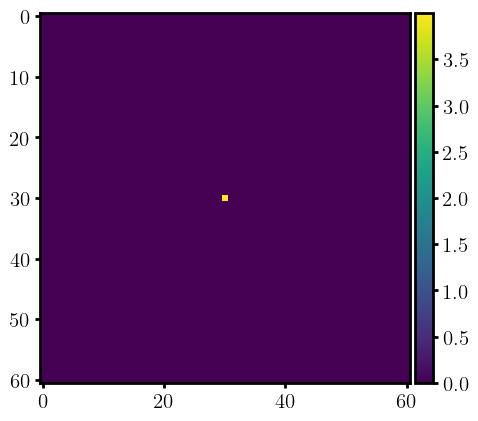

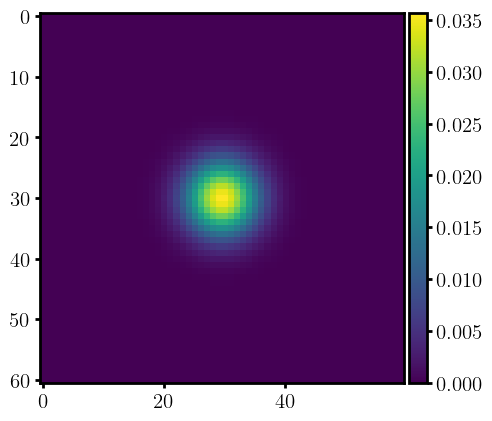

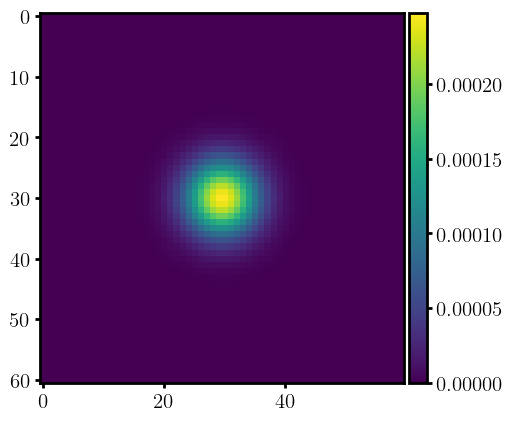

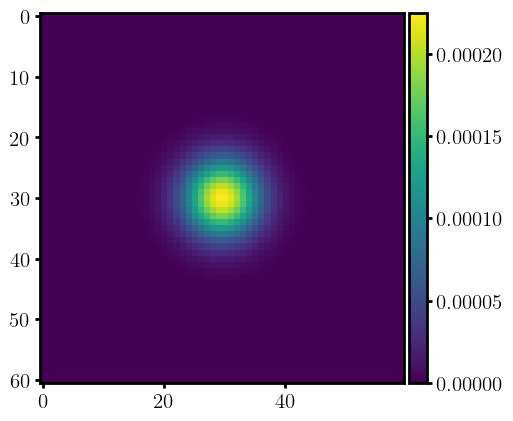

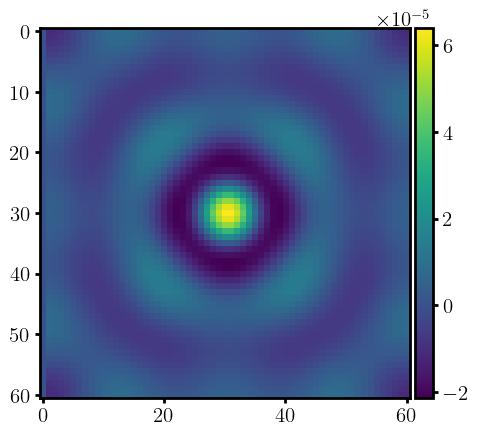

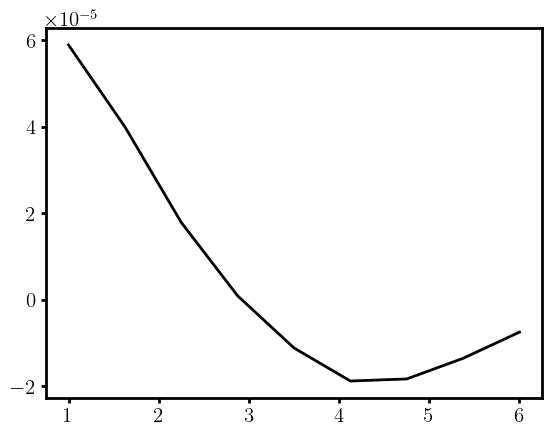

In [17]:
# make single object profile
baseMap, boxMask, wcs = make_stampmap()
dmap = make_ptsrc_map(baseMap, plot=True)
gmap = gaussify_map(dmap, plot=True)
gmap = renorm_map(gmap, renorm=2.45e-4, plot=True)
gmap = beam_map(gmap)
filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=1)
RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
plot_mean_tau(RAp, filt_one_profile, c='k', label='single object')

0.25006557807041113
0.25006557807041113
0.25006557807041113
0.25006557807041113
0.25006557807041113
0.25006557807041113
0.25006557807041113
0.25006557807041113


/tmp/ipykernel_177230/2793444550.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure()


0.25006557807041113
0.25006557807041113
0.25006557807041113
0.25006557807041113
0.25006557807041113
0.25006557807041113
0.25006557807041113


Text(0, 0.5, '$\\langle \\tau \\rangle$')

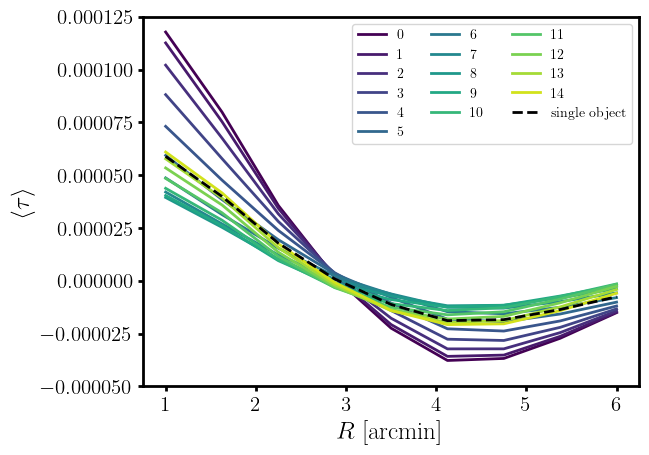

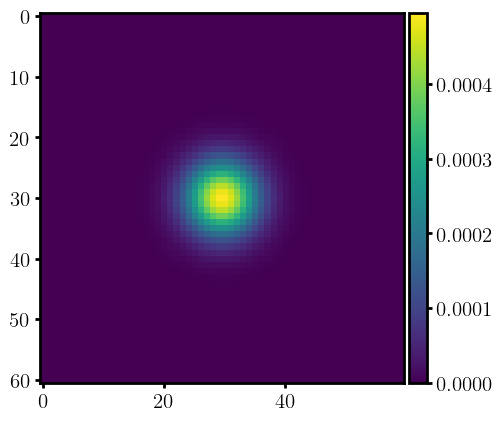

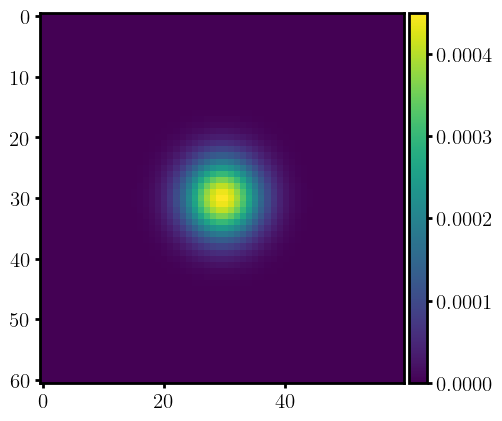

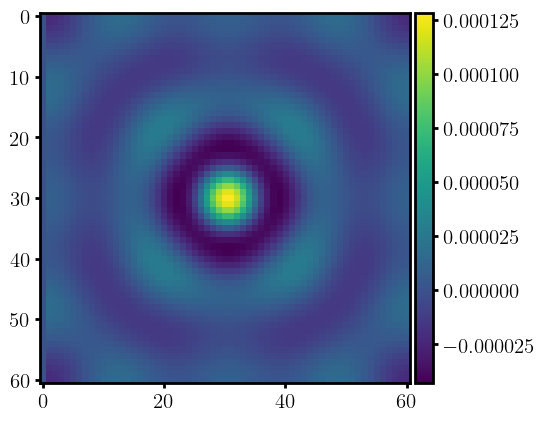

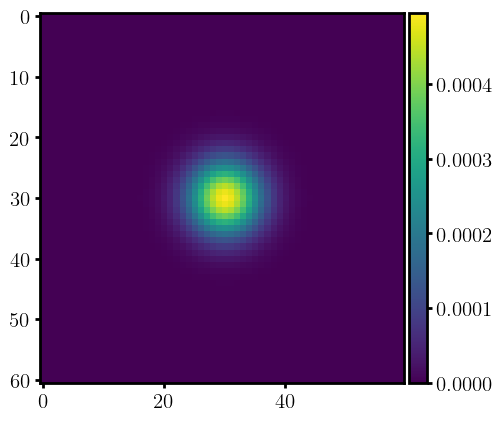

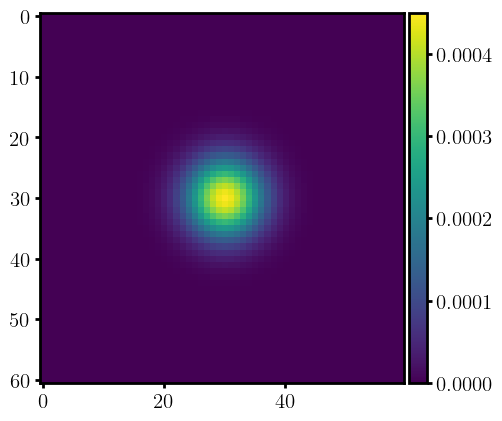

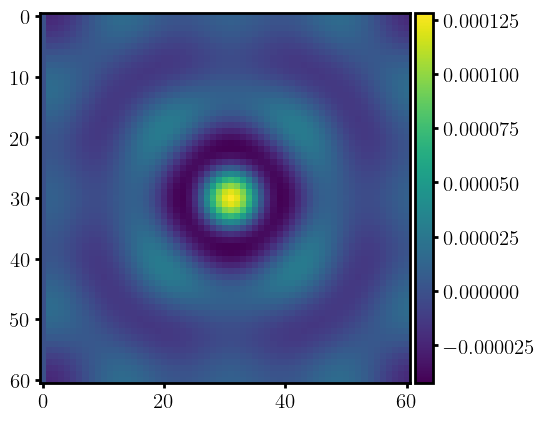

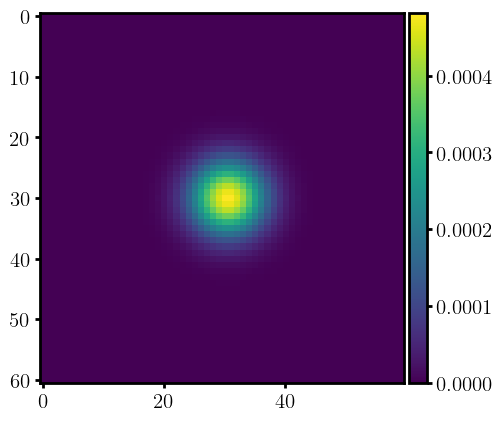

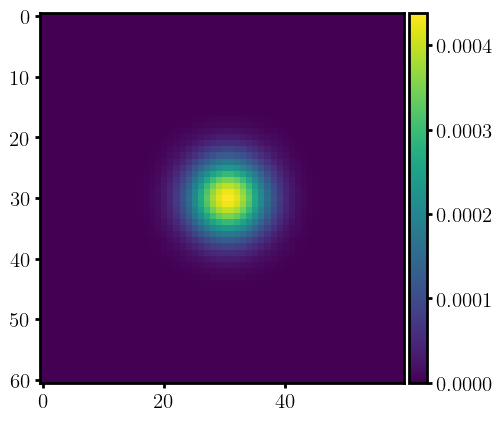

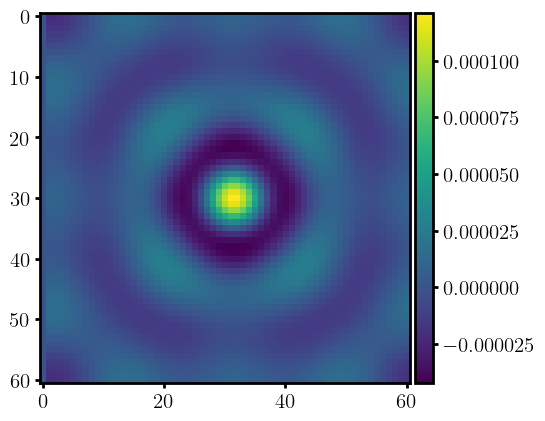

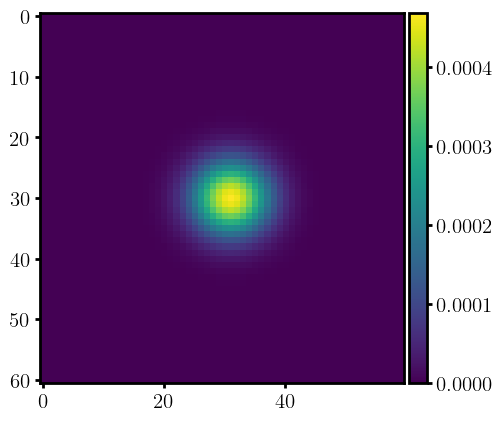

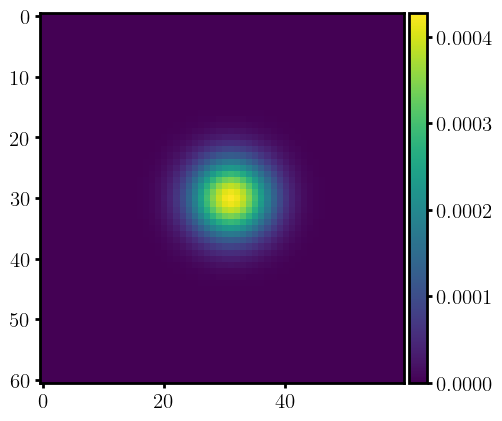

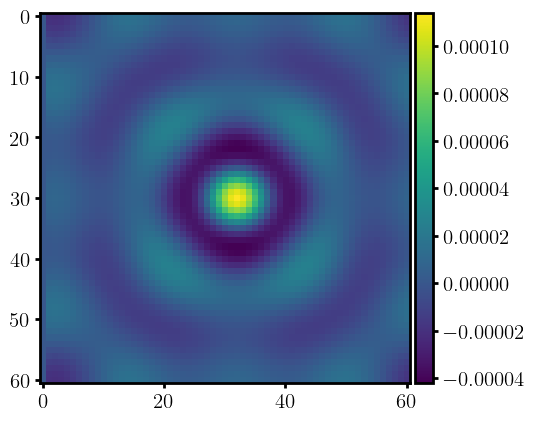

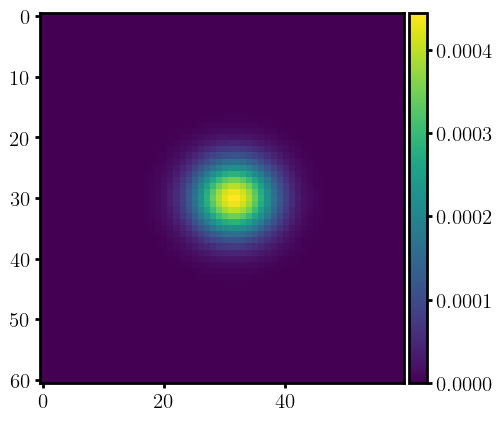

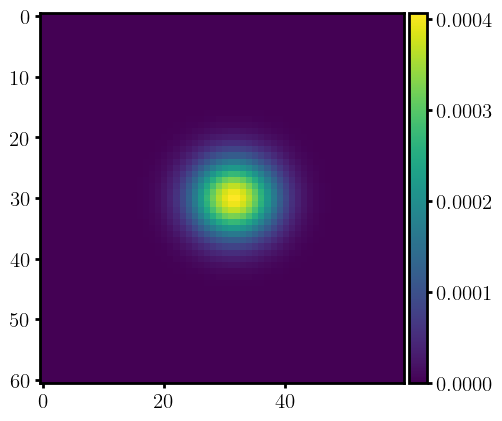

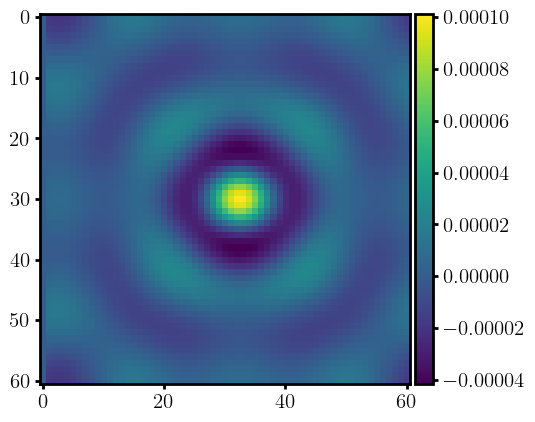

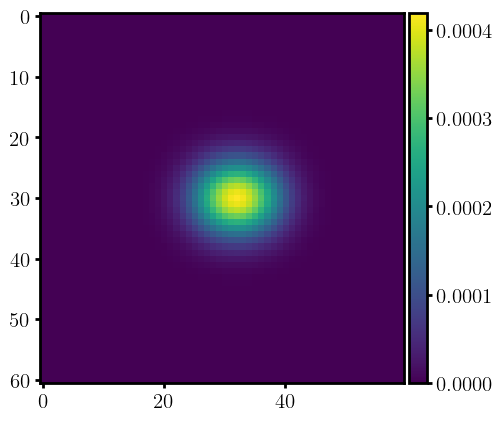

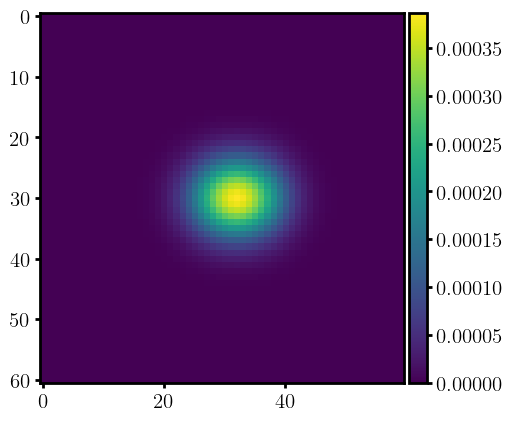

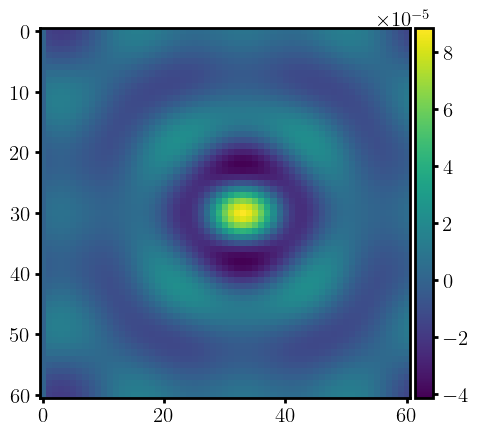

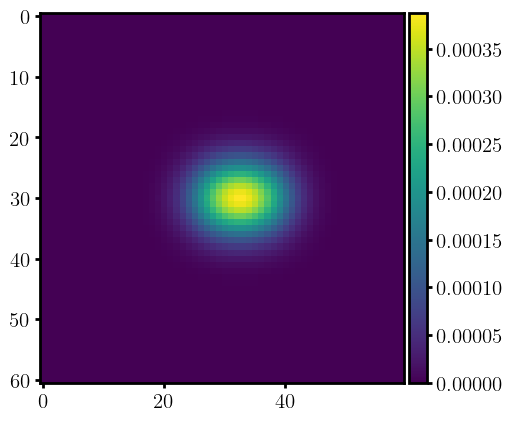

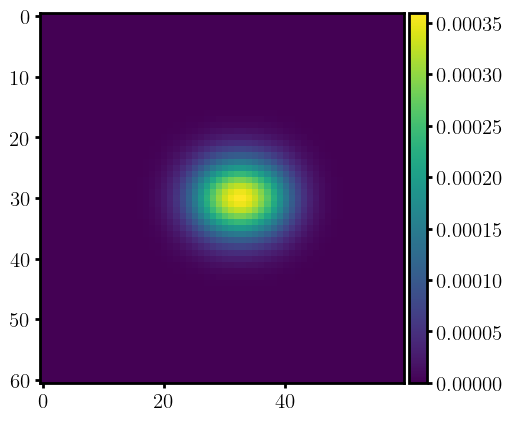

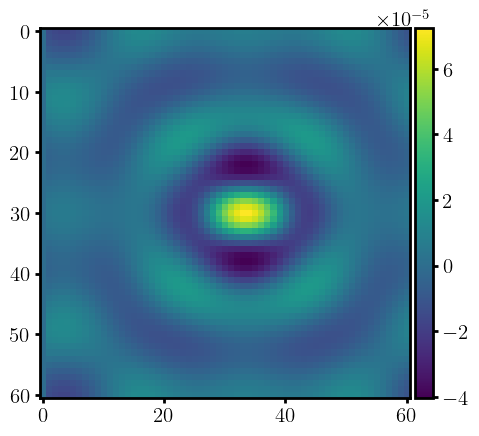

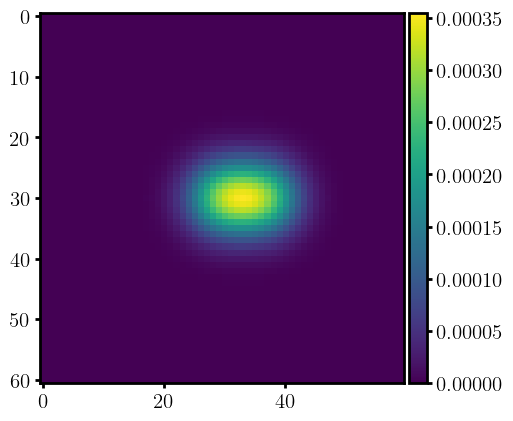

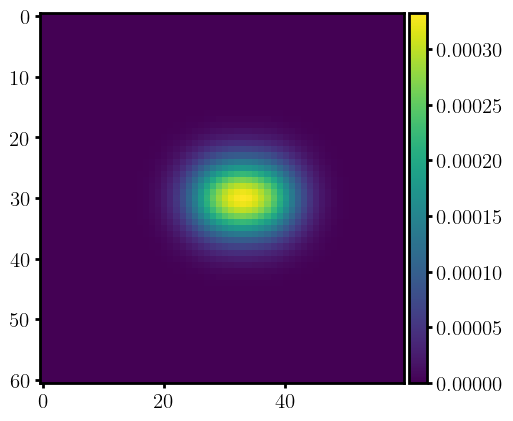

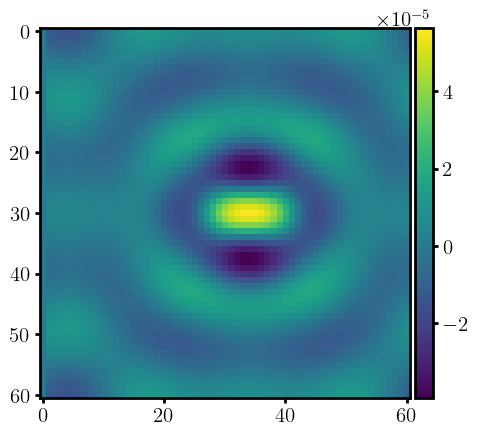

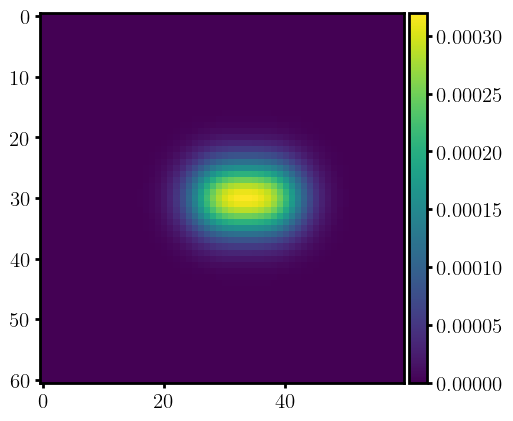

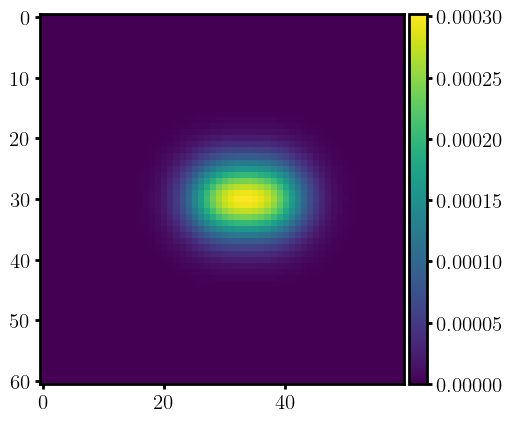

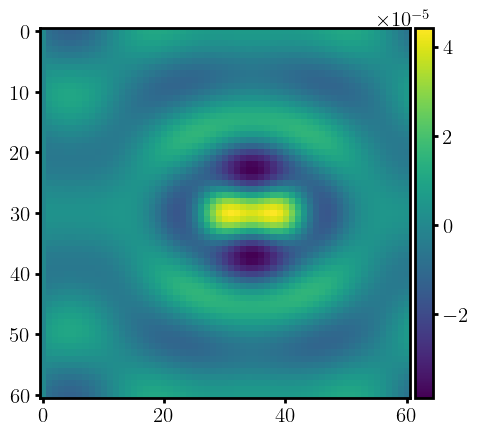

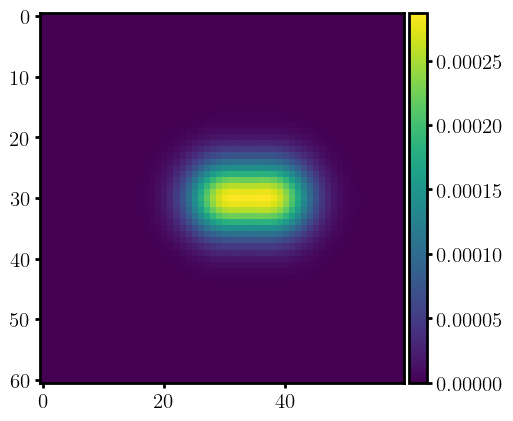

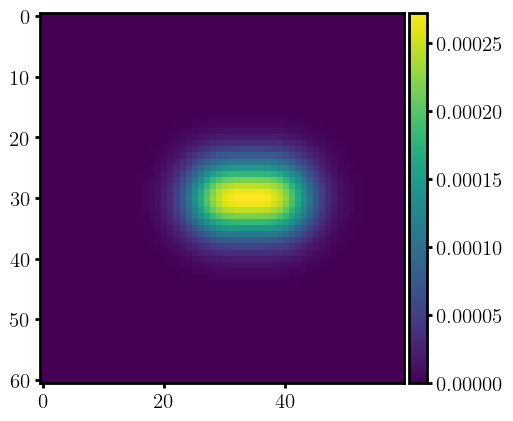

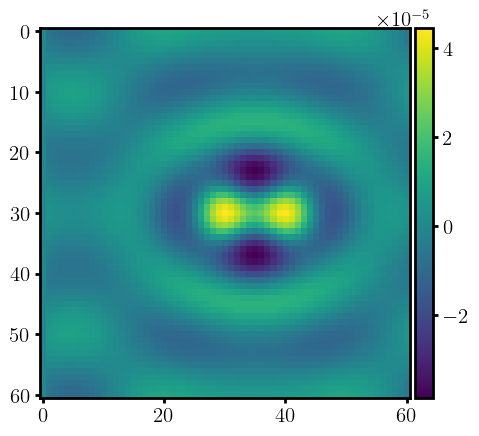

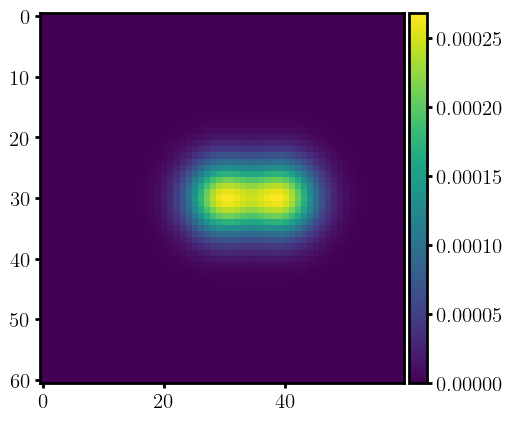

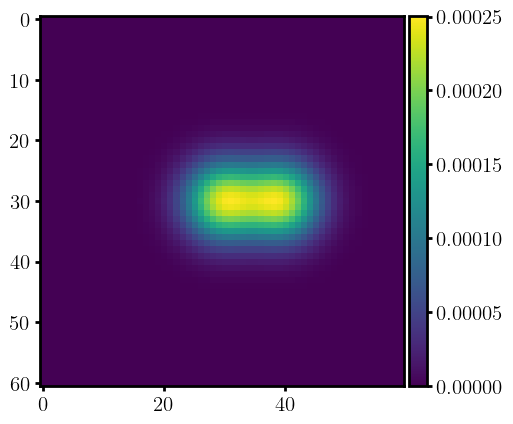

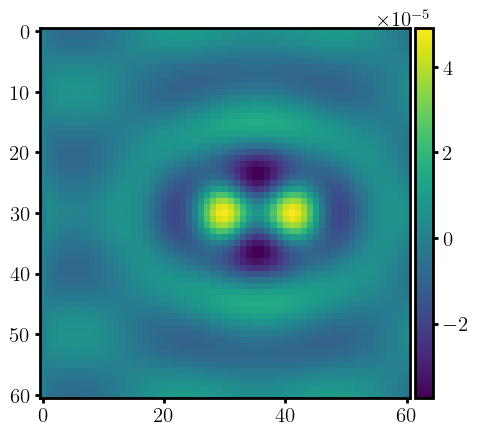

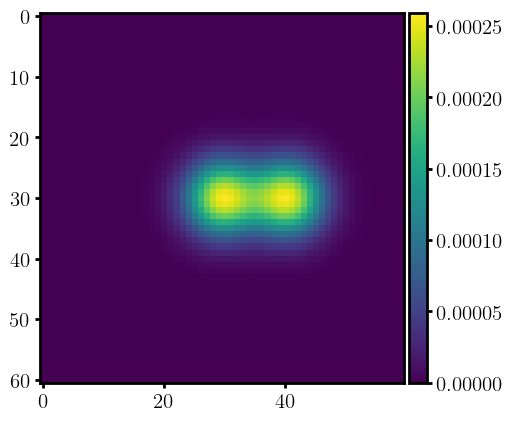

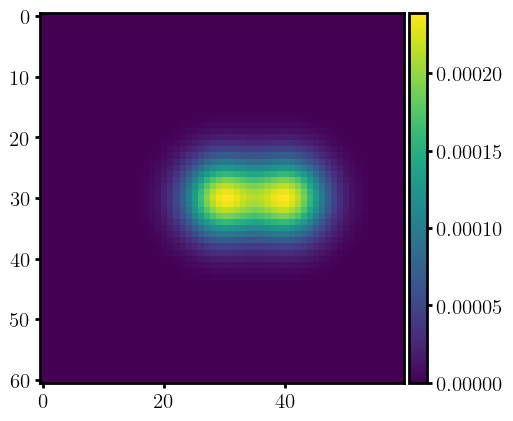

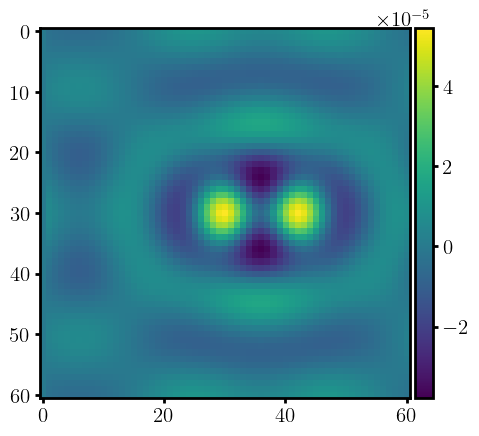

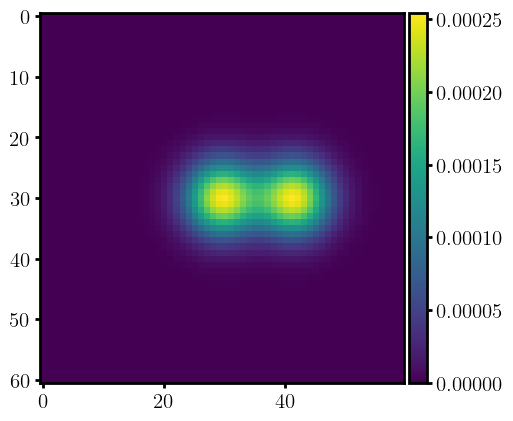

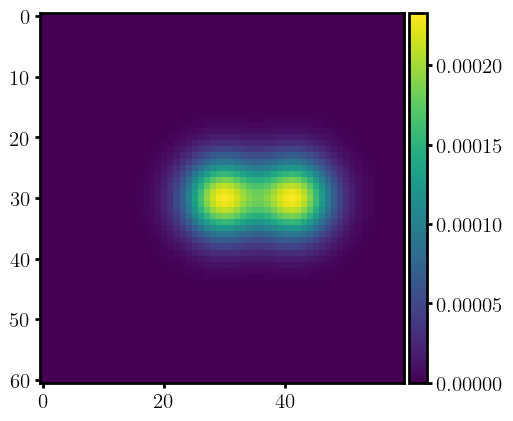

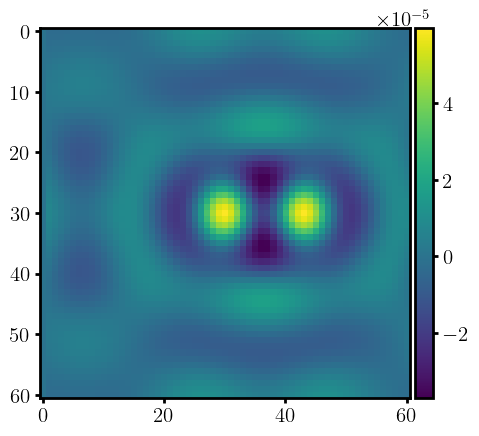

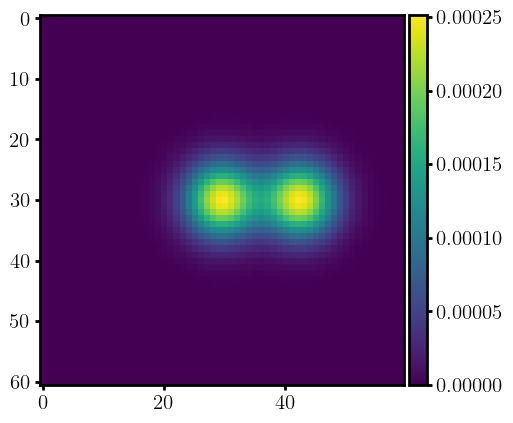

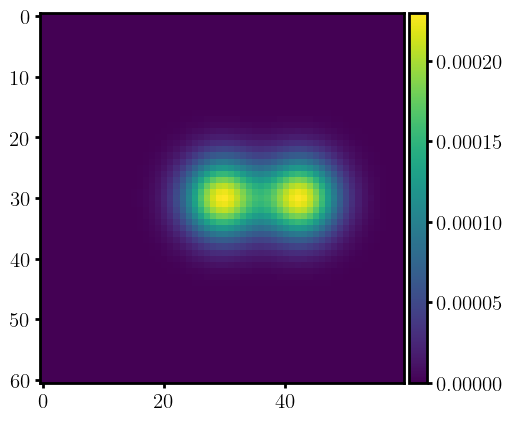

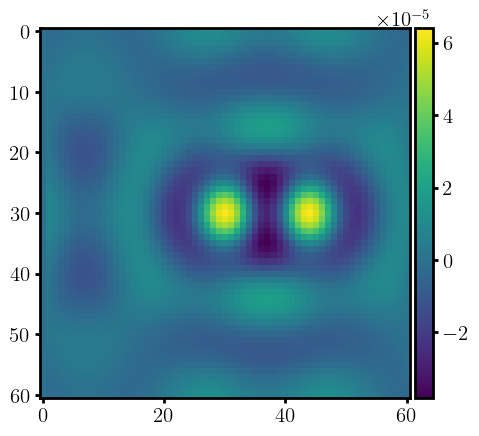

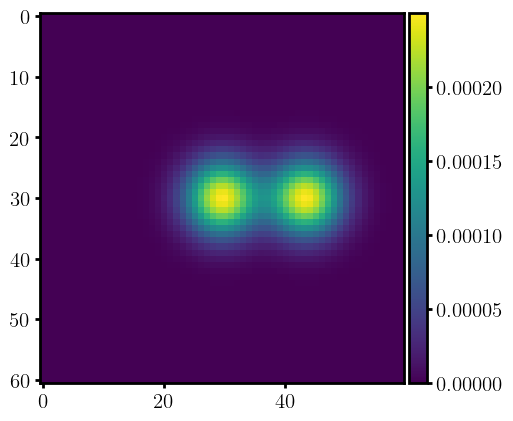

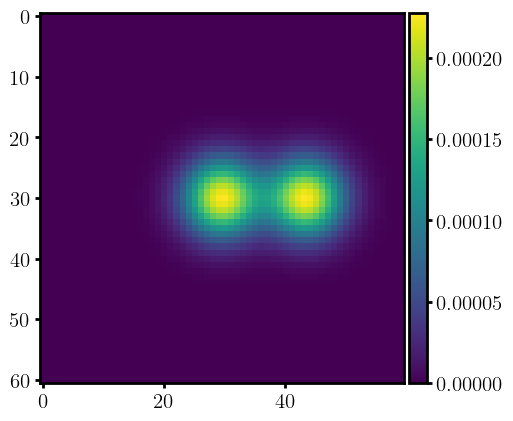

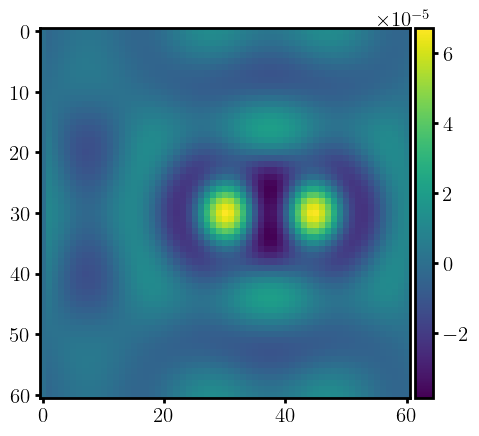

In [68]:
n = 15
f, ax = plt.subplots(1,1)
for i in range(n):
    baseMap, boxMask, wcs = make_stampmap()
    dmap = make_2ptsrc_map(baseMap, sep=i, plot=False)
    gmap = gaussify_map(dmap, plot=False)
    gmap = renorm_map(gmap, renorm=2.45e-4)
    gmap = beam_map(gmap)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=True)
    RAp, filt_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    plot_mean_tau(RAp, filt_profile, ax=ax, c=plt.get_cmap('viridis')(i/n), label=str(i))
plot_mean_tau(RAp, filt_one_profile, ax=ax, ls='--', c='k', label='single object')
ax.set_ylim(-0.00005, 0.000125)
ax.legend(ncol=3, fontsize=10)
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')

## Check ratio between profiles

Text(0, 0.5, '$\\langle \\tau \\rangle$')

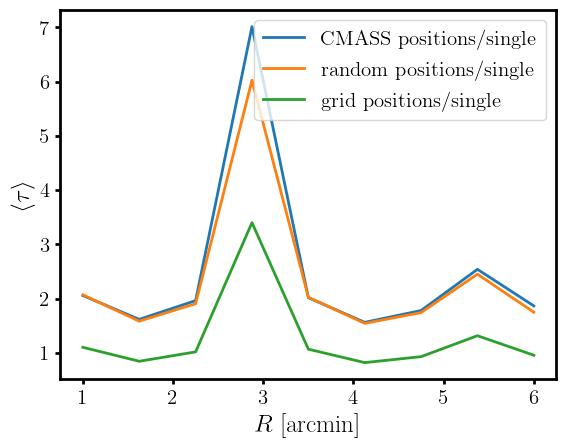

In [75]:
ts_cmass_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10s10_tau-fwhm_renorm2.45e-4_v3_c-1.0_willfilt/tauring_tau_sgn_uniformweight_measured.txt')
ts_rand_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10x10_randradec_tau-fwhm5_renorm2.45e-4_v4_c-1.0_willfilt/tauring_tau_sgn_uniformweight_measured.txt')
ts_grid_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/grid_10x10_10x10src_periodic_v2_renorm2.45e-04_c-1.0_beam1.6_willfilt/tauring_tau_sgn_uniformweight_measured.txt')
f, ax = plt.subplots(1,1)
ts_cmass_will[:,1]  *= rad2arcmin**2 / ring_areas
ts_rand_will[:,1]  *= rad2arcmin**2 / ring_areas
ts_grid_will[:,1]  *= rad2arcmin**2 / ring_areas
ax.plot(RAp, ts_cmass_will[:,1] / filt_one_profile, label='CMASS positions/single')
ax.plot(RAp, ts_rand_will[:,1] / filt_one_profile, label='random positions/single')
ax.plot(RAp, ts_grid_will[:,1] / filt_one_profile, label='grid positions/single')
# plot_mean_tau(r, profile_list[1] * rad2arcmin**2 / ring_areas, ax=ax, label='single object')
ax.legend()
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')
# ax.set_ylim(-0.00005, 0.000125)

[ 1.45253675e-04  9.67791689e-05  4.10673185e-05 -6.52189186e-07
 -2.92591996e-05 -4.60469609e-05 -4.31255510e-05 -3.07354516e-05
 -1.60138043e-05]


(0.5, 3.0)

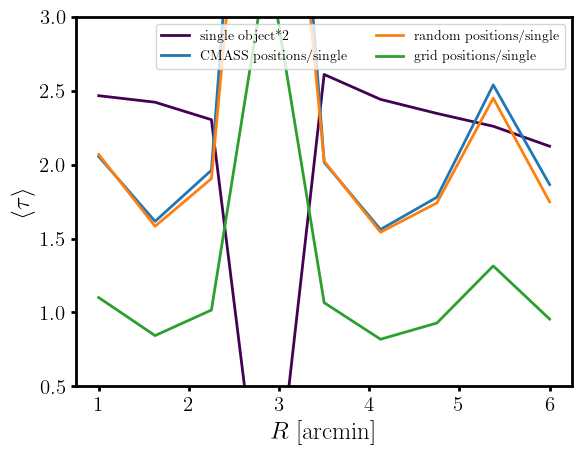

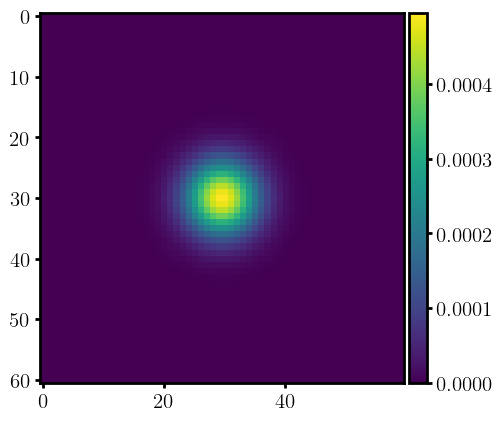

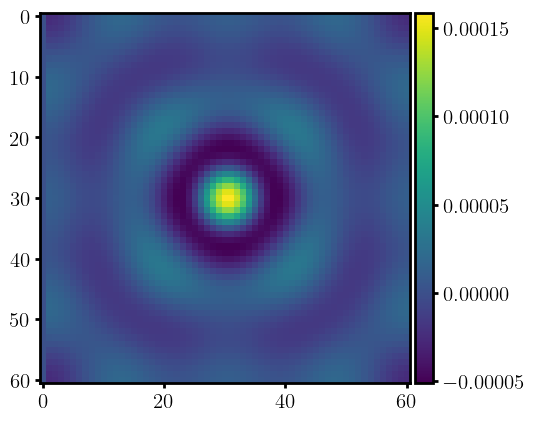

In [80]:
n = 1
f, ax = plt.subplots(1,1)
for i in range(n):
    baseMap, boxMask, wcs = make_stampmap()
    dmap = make_2ptsrc_map(baseMap, sep=i, plot=False)
    gmap = gaussify_map(dmap, plot=False)
    gmap = renorm_map(gmap, renorm=2.45e-4)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=1)
    RAp, filt_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    print(filt_profile)
    plot_mean_tau(RAp, filt_profile/filt_one_profile, ax=ax, c=plt.get_cmap('viridis')(i/n), label='single object*2')
# ax.plot(RAp, profile_list[1]  * rad2arcmin**2 / ring_areas, c='r')
ax.plot(RAp, ts_cmass_will[:,1] / filt_one_profile, label='CMASS positions/single')
ax.plot(RAp, ts_rand_will[:,1] / filt_one_profile, label='random positions/single')
ax.plot(RAp, ts_grid_will[:,1] / filt_one_profile, label='grid positions/single')
ax.legend(ncol=2, fontsize=10)
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')
ax.set_ylim(0.5,3)

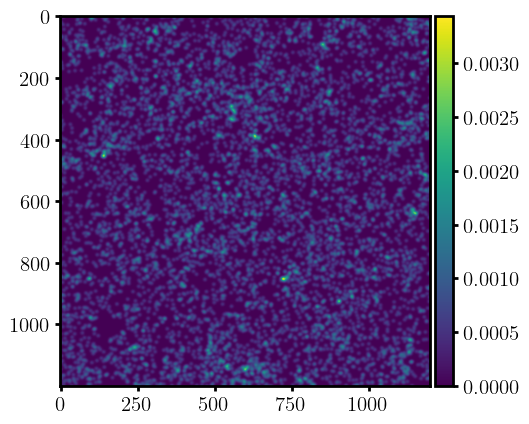

In [81]:
cmass_tau = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/cmass_m_10x10_tau-fwhm5_v3/cmass_m_10x10_tau-fwhm5_renorm2.45e-4_v3_image.fits')
im = plt.imshow(cmass_tau)
colorbar(im)

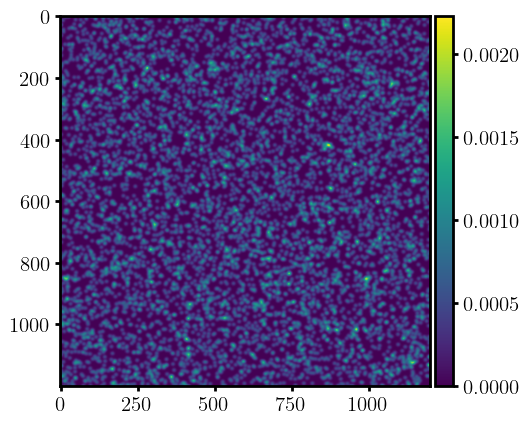

In [82]:
rand_tau = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/cmass_m_10x10_randradec_tau-fwhm5_renorm2.45e-4_v4/cmass_m_10x10_randradec_tau-fwhm5_renorm2.45e-4_v4_image.fits')
im = plt.imshow(rand_tau)
colorbar(im)

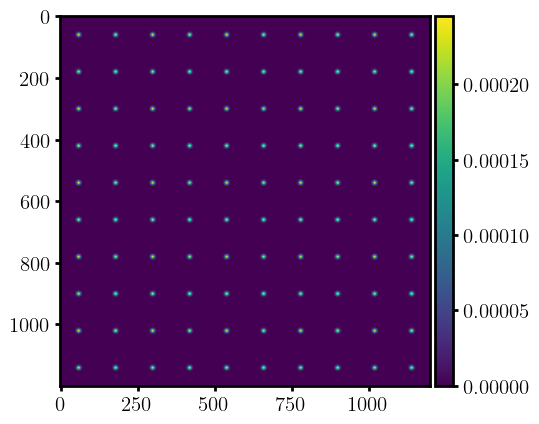

In [83]:
grid_tau = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/grid_10x10_10x10src_periodic_v2/grid_10x10_10x10src_periodic_v2_renorm2.45e-04_image.fits')
im = plt.imshow(grid_tau)
colorbar(im)

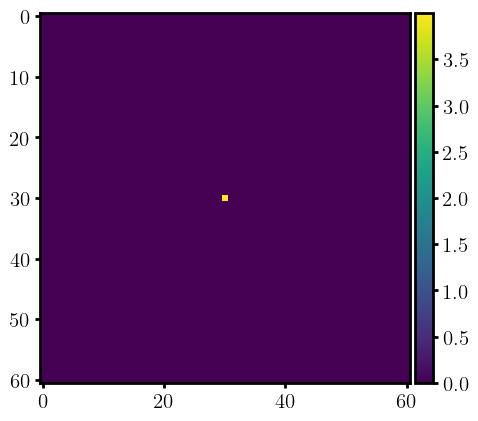

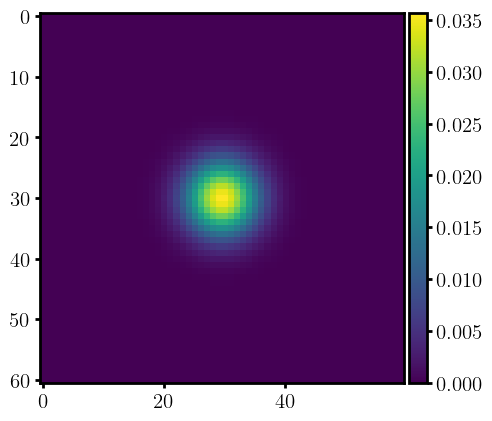

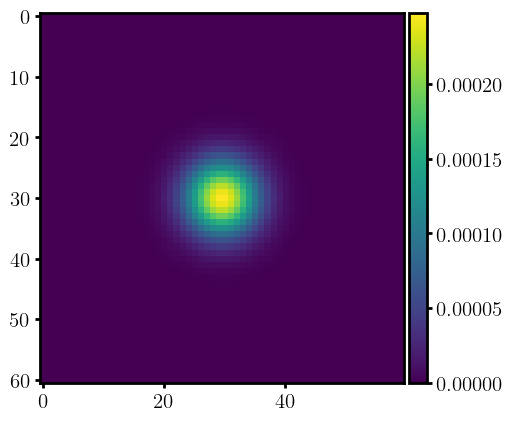

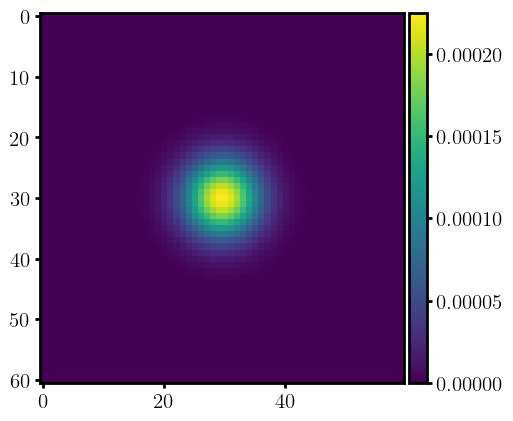

In [89]:
# compare to single source
baseMap, boxMask, wcs = make_stampmap()
dmap = make_ptsrc_map(baseMap, plot=True)
gmap = gaussify_map(dmap, fwhm=5., plot=True)
gmap = renorm_map(gmap)
gmap = beam_map(gmap)

In [90]:
print(np.sum(gmap.data))
print(np.sum(gmap.data) * 7659)
print(np.sum(cmass_tau))
print(np.sum(gmap.data) * 7666)
print(np.sum(rand_tau))
print(np.sum(gmap.data) * 100)
print(np.sum(grid_tau))

0.027753425804245405
212.56348823471555
415.26791240098123
212.75776221534528
414.9018311875316
2.7753425804245406
2.8781305215650788


# HEYO!

In [187]:
fwhm = 5.
sigma = fwhm / np.sqrt(8.*np.log(2))
denorm = 2. * np.pi * sigma**2
pixarea = 0.25 # approx
peaktau = 2.45e-4

In [92]:
print(denorm, 1/denorm, 1/(4*denorm))

28.327250886419964 0.03530169602442425 0.008825424006106062


414.70566853431853
103.67641713357963
2.878130521565079
0.7195326303912698
2.7753425804245406
0.6938356451061352


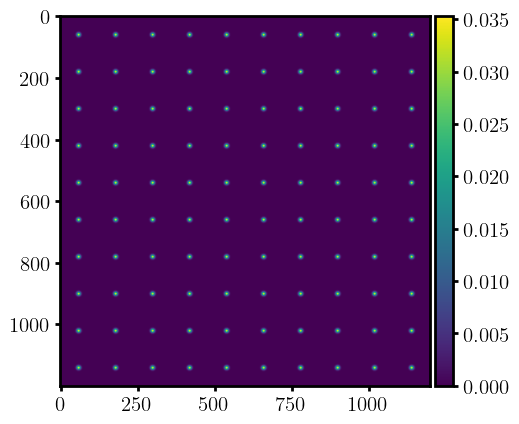

In [114]:
grid_tau_orig = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/catalog/grid_10x10_10x10src_periodic/mock_count_gauss_car.fits')
print(np.sum(grid_tau_orig))
print(np.sum(grid_tau_orig) * pixarea) #approximate pixel area in arcmin^2
print(np.sum(grid_tau_orig * denorm * peaktau))
print(np.sum(grid_tau_orig * denorm * peaktau * pixarea))
print(np.sum(gmap.data) * 100)
print(np.sum(gmap.data) * 100 * pixarea)
f = plt.figure()
im = plt.imshow(grid_tau_orig)
colorbar(im)

31660.731536654315
7915.182884163579
219.7310639441668
54.9327659860417
212.56348823471555
53.14087205867889


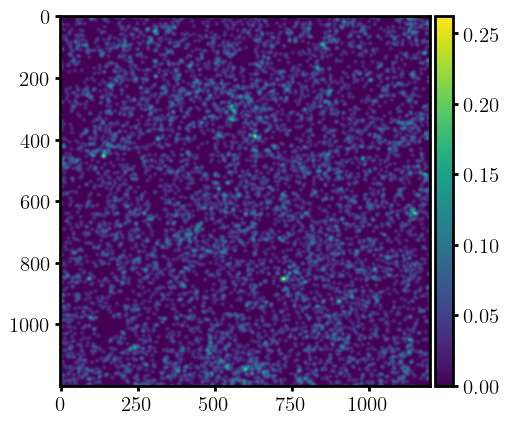

In [94]:
cmass_tau_orig = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/catalog/cmass_m_10x10_v2_fwhm5/mock_count_gauss_car.fits')
print(np.sum(cmass_tau_orig)) #[ct arcmin^-2]
print(np.sum(cmass_tau_orig) * pixarea) #approximate integrated number count by multiplying by approx pixel area in arcmin^2
print(np.sum(cmass_tau_orig * denorm * peaktau))
print(np.sum(cmass_tau_orig  * denorm * peaktau * pixarea))
print(np.sum(gmap.data) * 7659)
print(np.sum(gmap.data) * 7659 * pixarea)
f = plt.figure()
im = plt.imshow(cmass_tau_orig)
colorbar(im)

31632.82088265597
7908.205220663993
219.53735908010432
54.88433977002608
212.75776221534528
53.18944055383632


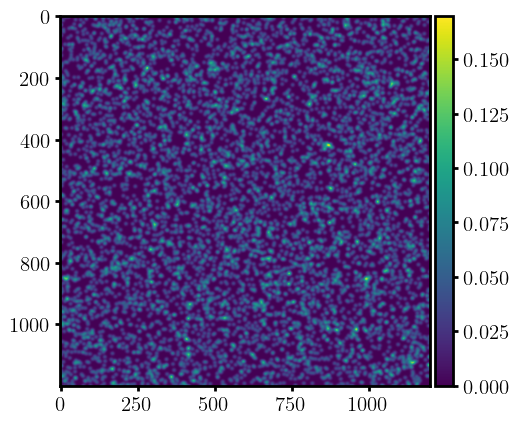

In [95]:
rand_tau_orig = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/catalog/cmass_m_10x10_sig5_randradec/mock_count_gauss_car.fits')
rand_tau_orig_renorm = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/catalog/cmass_m_10x10_sig5_randradec/mock_count_gauss_car_renorm2.45e-4_nobeam.fits')
print(np.sum(rand_tau_orig))
print(np.sum(rand_tau_orig) * pixarea) #approximate pixel area in arcmin^2
print(np.sum(rand_tau_orig * denorm * peaktau))
print(np.sum(rand_tau_orig * denorm * peaktau * pixarea))
print(np.sum(gmap.data) * 7666)
print(np.sum(gmap.data) * 7666 * 0.25)
f = plt.figure()
im = plt.imshow(rand_tau_orig)
colorbar(im)

414.9018311875316
103.7254577968829
59782.60540636419
14945.651351591048
212.75776221534528
53.18944055383632


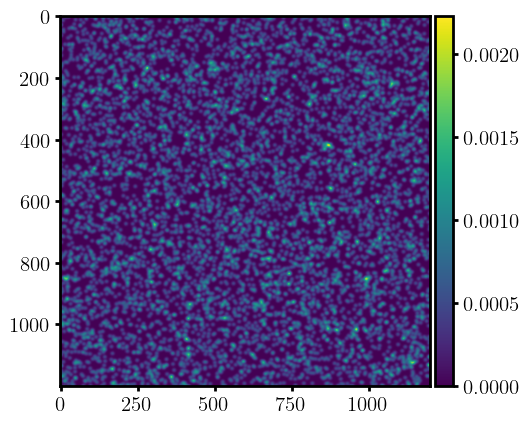

In [97]:
rand_tau_orig_renorm = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/catalog/cmass_m_10x10_sig5_randradec/mock_count_gauss_car_renorm2.45e-4_nobeam.fits')
print(np.sum(rand_tau_orig_renorm))
print(np.sum(rand_tau_orig_renorm) * pixarea) #approximate pixel area in arcmin^2
print(np.sum(rand_tau_orig_renorm / denorm / peaktau))
print(np.sum(rand_tau_orig_renorm / denorm / peaktau * pixarea))
print(np.sum(gmap.data) * 7666)
print(np.sum(gmap.data) * 7666 * 0.25)
f = plt.figure()
im = plt.imshow(rand_tau_orig_renorm)
colorbar(im)

In [100]:
print(np.sum(rand_tau_orig_renorm / denorm / peaktau * pixarea))
print(np.sum(rand_tau_orig * pixarea))

14945.651351591048
7908.205220663993


219.53735908010424
54.88433977002606
212.75776221534528
53.18944055383632


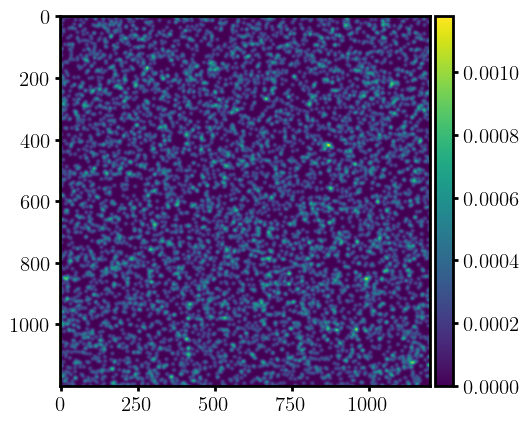

In [107]:
rand_tau_new = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/cmass_m_10x10_randradec_fwhm5_v5/cmass_m_10x10_randradec_fwhm5_v5_renorm2.45e-04_image.fits')
print(np.sum(rand_tau_new))
print(np.sum(rand_tau_new) * pixarea) #approximate pixel area in arcmin^2
print(np.sum(gmap.data) * 7666)
print(np.sum(gmap.data) * 7666 * 0.25)
f = plt.figure()
im = plt.imshow(rand_tau_new)
colorbar(im)

In [106]:
print(np.sum(rand_tau_orig_renorm / denorm / peaktau * pixarea))
print(np.sum(rand_tau_orig * pixarea))

14945.651351591048
7908.205220663993


### wat

In [120]:
rand_tau_orig = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/catalog/cmass_m_10x10_sig5_randradec/mock_count_gauss_car.fits')
rand_tau_orig_renorm = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/catalog/cmass_m_10x10_sig5_randradec/mock_count_gauss_car_renorm2.45e-4_nobeam.fits')
rand_tau_fm = baseMap.copy()
rand_tau_fm.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/cmass_m_10x10_randradec_fwhm5_v5/cmass_m_10x10_randradec_fwhm5_v5_renorm2.45e-04_beam1.6_flatmap.fits')

reading from /home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/cmass_m_10x10_randradec_fwhm5_v5/cmass_m_10x10_randradec_fwhm5_v5_renorm2.45e-04_beam1.6_flatmap.fits


In [121]:
print(np.sum(rand_tau_orig))
print(np.sum(rand_tau_orig_renorm / denorm / peaktau))
print(np.sum(rand_tau_fm.data))

31632.82088265597
59782.60540636419
219.53735908010412


reading from /home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/cmass_m_10x10_tau-fwhm5_v3/cmass_m_10x10_tau-fwhm5_renorm2.45e-4_v3_flatmap.fits
415.26791240098123


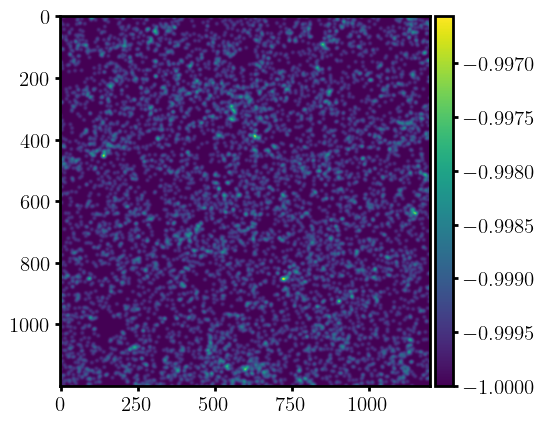

In [126]:
cmass_tau_fm = rand_tau_fm.copy()
cmass_tau_fm.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/cmass_m_10x10_tau-fwhm5_v3/cmass_m_10x10_tau-fwhm5_renorm2.45e-4_v3_flatmap.fits')
print(np.sum(cmass_tau_fm.data + 1))
im = plt.imshow(cmass_tau_fm.data)
colorbar(im)

#### somehow we got a factor of 2 between making the map in thumbstack and renorming by hand
#### unclear how bc it's correct in the notebook that made the maps...rip

### Redoing maps and rerun thumbstack

In [133]:
ts_rand_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10x10_randradec_tau-fwhm5_renorm2.45e-4_v4_c-1.0_willfilt/tauring_tau_sgn_uniformweight_measured.txt')
ts_rand_2 = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10x10_randradec_fwhm5_v5/tauring_tau_sgn_uniformweight_measured.txt')
ts_rand_will[:,1]  *= rad2arcmin**2 / ring_areas
ts_rand_2[:,1]  *= rad2arcmin**2 / ring_areas

Text(0, 0.5, '$\\langle \\tau \\rangle$')

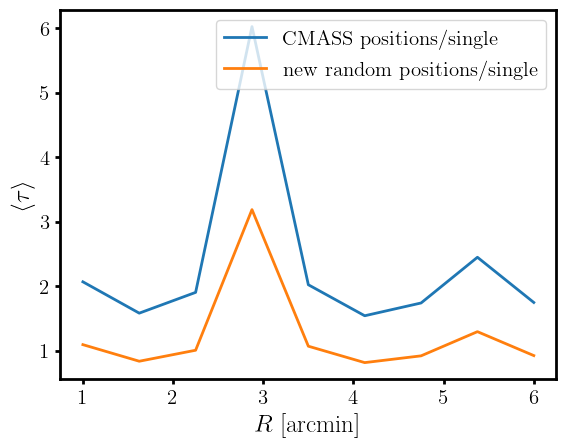

In [134]:
f, ax = plt.subplots(1,1)
ax.plot(RAp, ts_rand_will[:,1] / filt_one_profile, label='CMASS positions/single')
ax.plot(RAp, ts_rand_2[:,1] / filt_one_profile, label='new random positions/single')
# plot_mean_tau(r, profile_list[1] * rad2arcmin**2 / ring_areas, ax=ax, label='single object')
ax.legend()
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')
# ax.set_ylim(-0.00005, 0.000125)

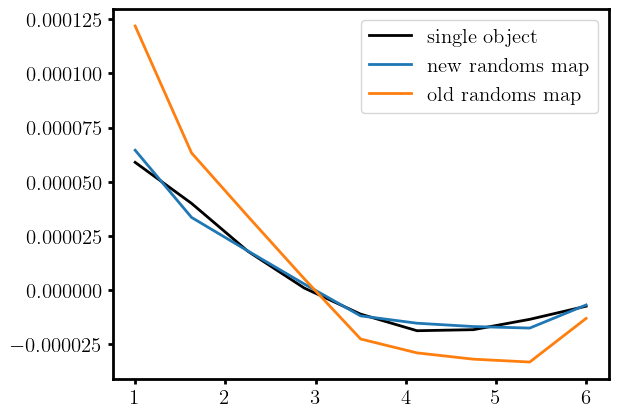

In [132]:
f, ax = plt.subplots(1,1)
plot_mean_tau(RAp, filt_one_profile, ax=ax, c='k', label='single object')
plot_mean_tau(RAp, ts_rand_2[:,1], ax=ax, label='new randoms map')
plot_mean_tau(RAp, ts_rand_will[:,1], ax=ax, label='old randoms map')
ax.legend()

## Yay~
## well this means the tau maps we've been using have been off by 2 :(

### Checking CMASS positions also...

In [155]:
ts_cmass_will = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10s10_tau-fwhm_renorm2.45e-4_v3_c-1.0_willfilt/tauring_tau_sgn_uniformweight_measured.txt')
ts_cmass_2 = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10x10_fwhm5_v5/tauring_tau_sgn_uniformweight_measured.txt')
ts_cmass_will[:,1]  *= rad2arcmin**2 / ring_areas
ts_cmass_2[:,1]  *= rad2arcmin**2 / ring_areas

In [157]:
print(ts_cmass_will[:,1])
print(ts_cmass_2[:,1])

[ 1.21048396e-04  6.45850036e-05  3.49731254e-05  5.95957388e-06
 -2.25985166e-05 -2.94537445e-05 -3.27051236e-05 -3.45366576e-05
 -1.40595896e-05]
[ 6.56339565e-05  3.41739179e-05  1.85053596e-05  3.15339440e-06
 -1.19575723e-05 -1.55848849e-05 -1.73052899e-05 -1.82744110e-05
 -7.43936260e-06]


Text(0, 0.5, '$\\langle \\tau \\rangle$')

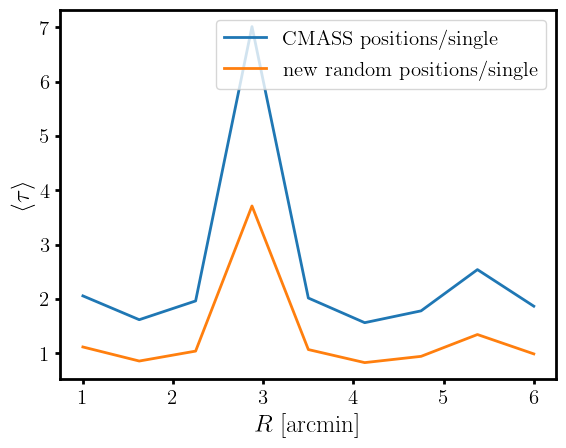

In [156]:
f, ax = plt.subplots(1,1)
ax.plot(RAp, ts_cmass_will[:,1] / filt_one_profile, label='CMASS positions/single')
ax.plot(RAp, ts_cmass_2[:,1] / filt_one_profile, label='new random positions/single')
# plot_mean_tau(r, profile_list[1] * rad2arcmin**2 / ring_areas, ax=ax, label='single object')
ax.legend()
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')
# ax.set_ylim(-0.00005, 0.000125)

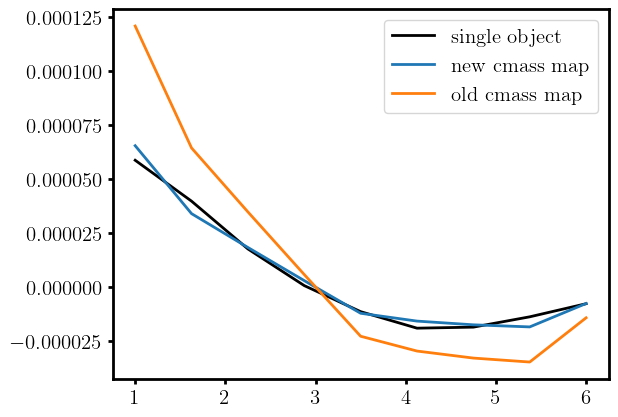

In [138]:
f, ax = plt.subplots(1,1)
plot_mean_tau(RAp, filt_one_profile, ax=ax, c='k', label='single object')
plot_mean_tau(RAp, ts_cmass_2[:,1], ax=ax, label='new cmass map')
plot_mean_tau(RAp, ts_cmass_will[:,1], ax=ax, label='old cmass map')
ax.legend()

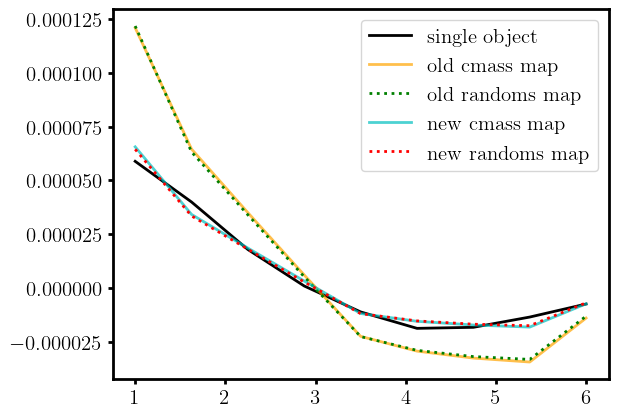

In [154]:
f, ax = plt.subplots(1,1)
plot_mean_tau(RAp, filt_one_profile, ax=ax, c='k', label='single object')
plot_mean_tau(RAp, ts_cmass_will[:,1], ax=ax, c='orange', label='old cmass map', alpha=0.7)
plot_mean_tau(RAp, ts_rand_will[:,1],ls=':',  c='g', ax=ax, label='old randoms map')
plot_mean_tau(RAp, ts_cmass_2[:,1], ax=ax, c='c', label='new cmass map', alpha=0.7)
plot_mean_tau(RAp, ts_rand_2[:,1], ls=':', c='r', ax=ax, label='new randoms map')

ax.legend()

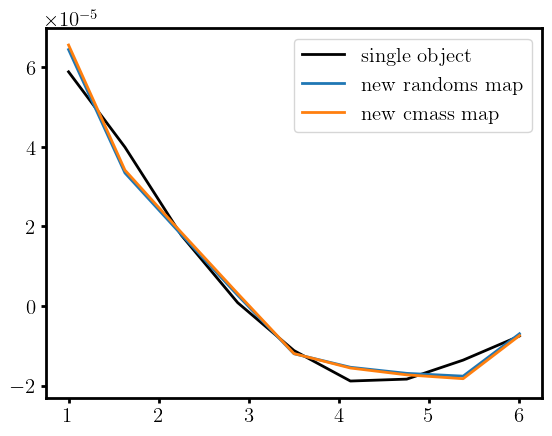

In [140]:
f, ax = plt.subplots(1,1)
plot_mean_tau(RAp, filt_one_profile, ax=ax, c='k', label='single object')
plot_mean_tau(RAp, ts_rand_2[:,1], ax=ax, label='new randoms map')
plot_mean_tau(RAp, ts_rand_will[:,1], ax=ax, label='old randoms map')
plot_mean_tau(RAp, ts_cmass_2[:,1], ax=ax, label='new cmass map')
plot_mean_tau(RAp, ts_cmass_will[:,1], ax=ax, label='old cmass map')
ax.legend()

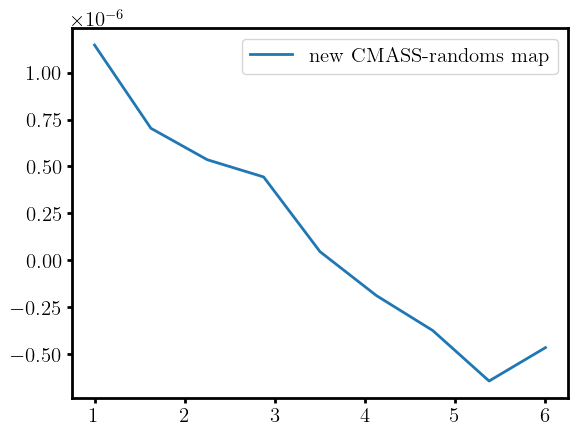

In [142]:
f, ax = plt.subplots(1,1)
plot_mean_tau(RAp, ts_cmass_2[:,1]-ts_rand_2[:,1], ax=ax, label='new CMASS-randoms map')
ax.legend()

Text(0, 0.5, '$\\langle \\tau \\rangle$')

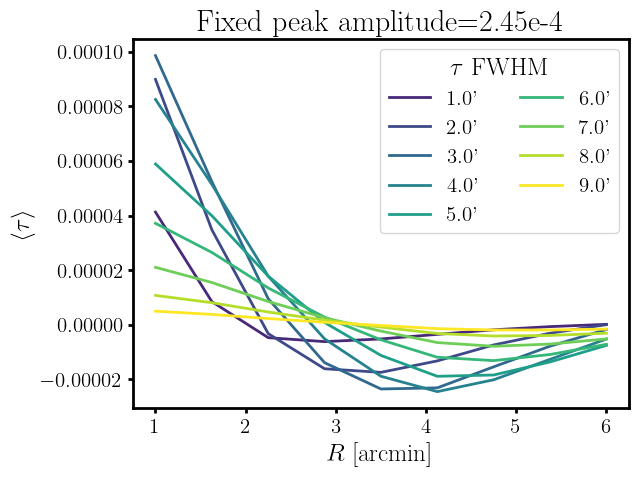

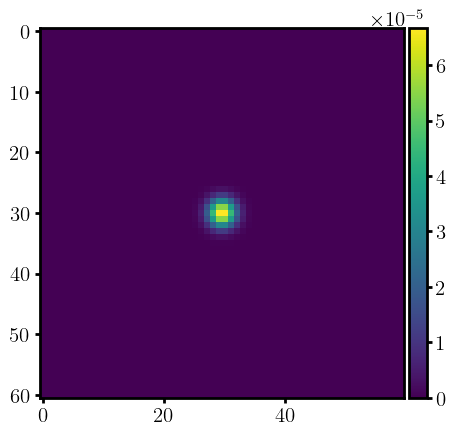

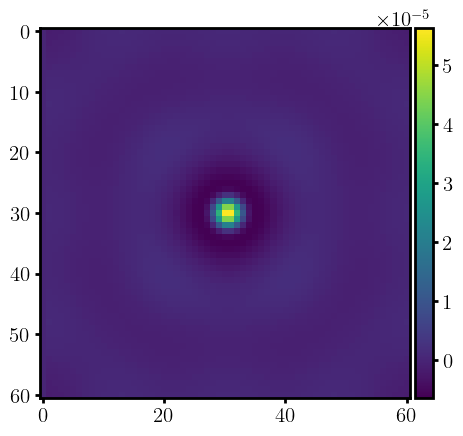

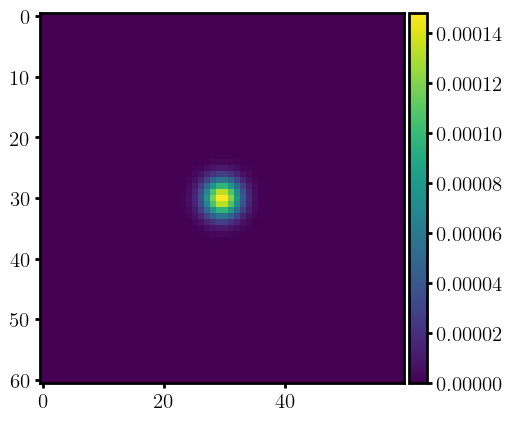

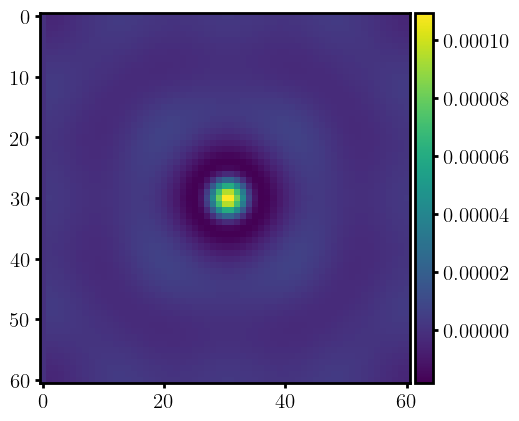

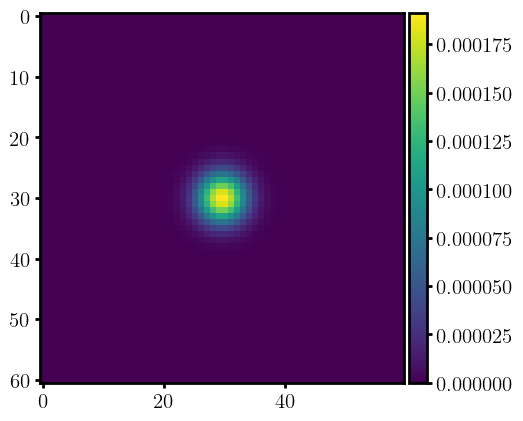

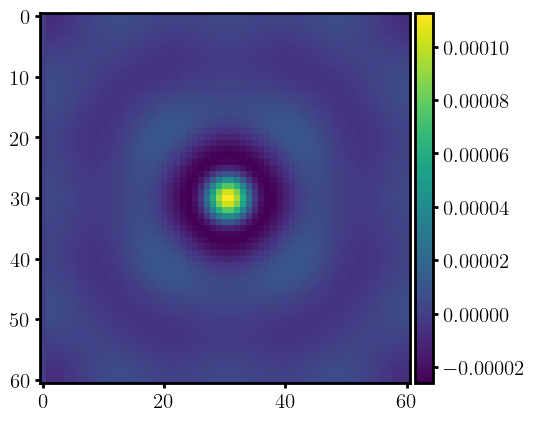

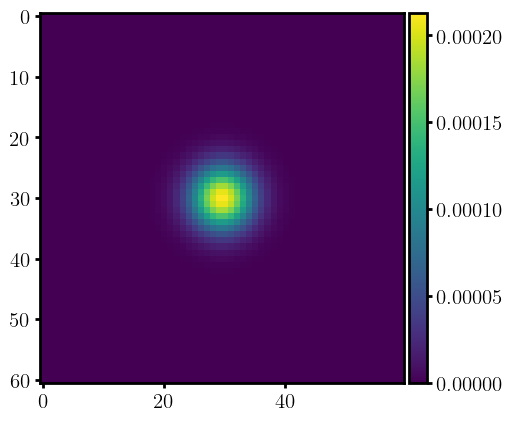

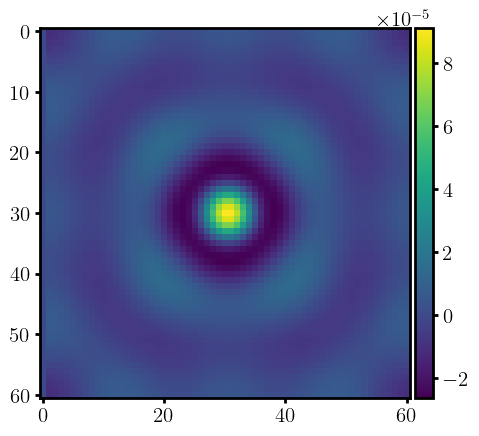

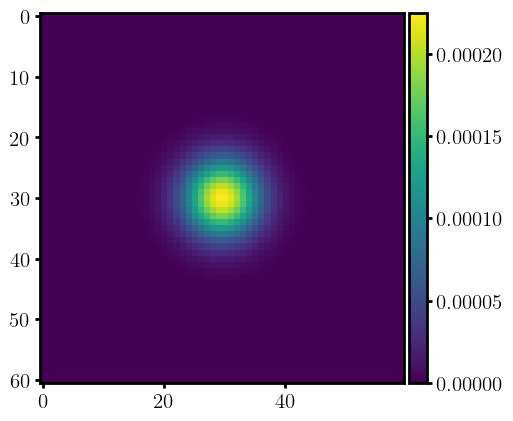

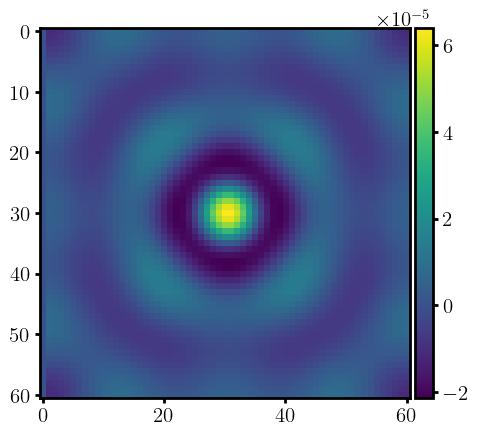

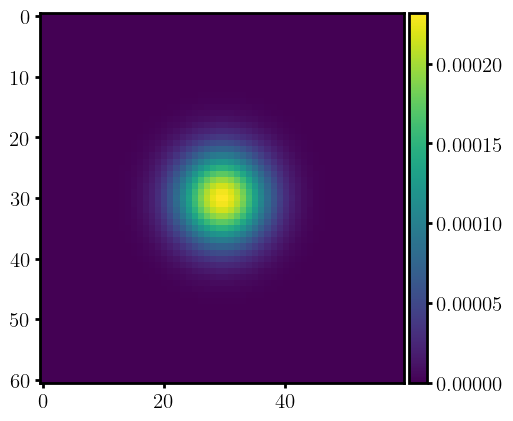

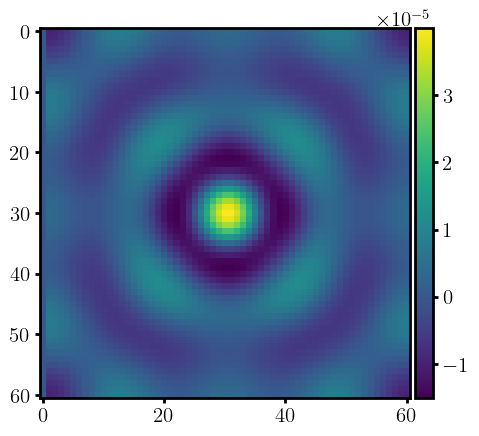

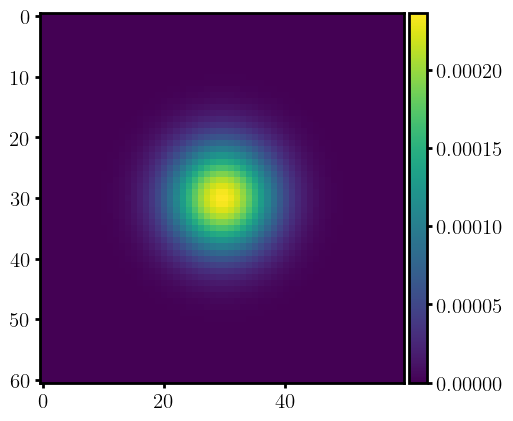

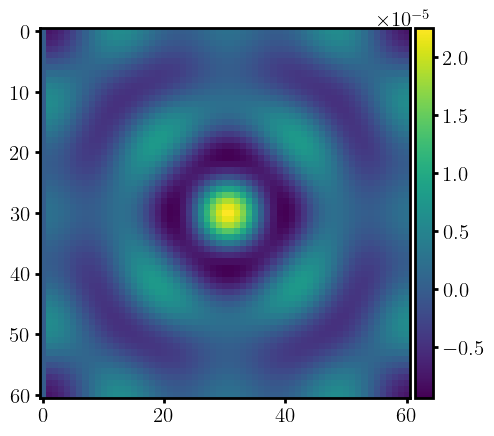

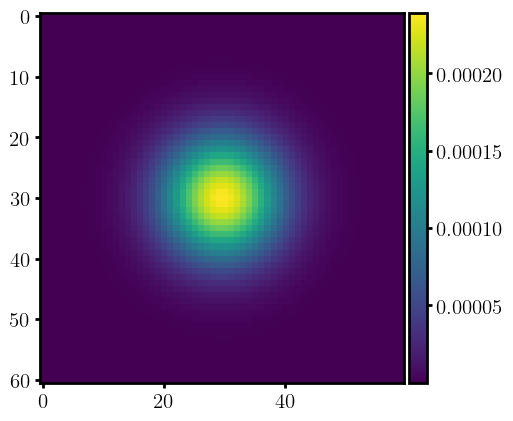

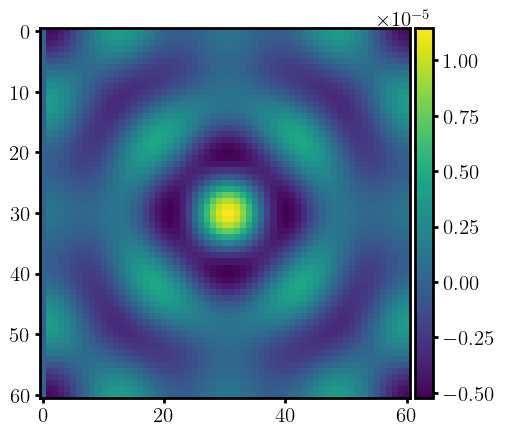

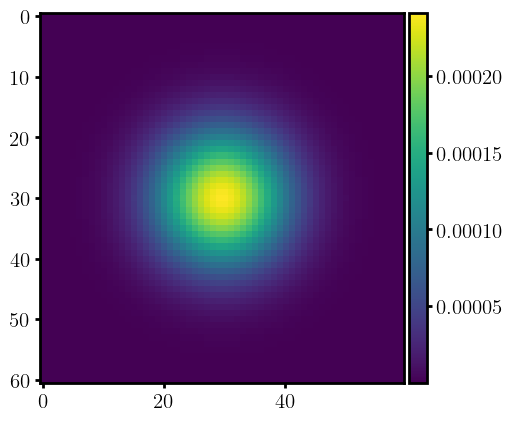

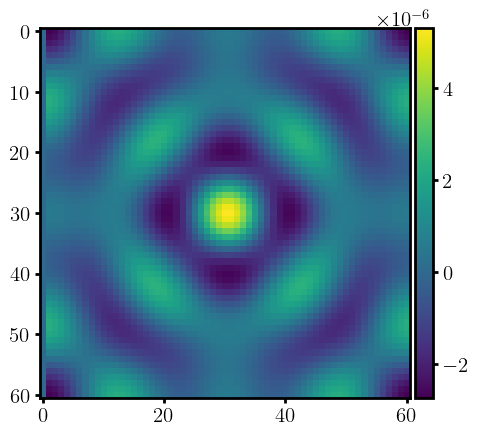

In [194]:
# make single object profile
fwhms = np.linspace(1,9,9)
f, ax = plt.subplots(1,1)
for fwhm in fwhms:
    baseMap, boxMask, wcs = make_stampmap()
    dmap = make_ptsrc_map(baseMap, plot=False)
    gmap = gaussify_map(dmap, fwhm=fwhm, plot=False)
    gmap = renorm_map(gmap, renorm=2.45e-4, profile_fwhm=fwhm, plot=False)
    gmap = beam_map(gmap)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=True)
    RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    plot_mean_tau(RAp, filt_one_profile, ax=ax, c=plt.get_cmap('viridis')(fwhm/len(fwhms)), label=str(fwhm)+'\'')
ax.legend(ncol=2, title=r'$\tau$ FWHM')
ax.set_title('Fixed peak amplitude=2.45e-4')
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')

Text(0, 0.5, '$\\langle \\tau \\rangle$')

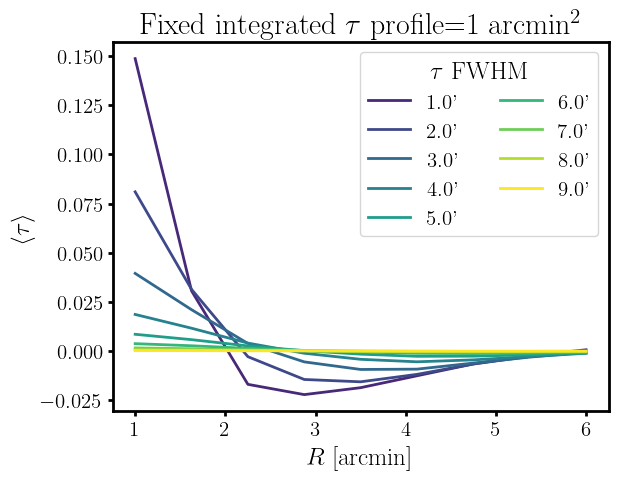

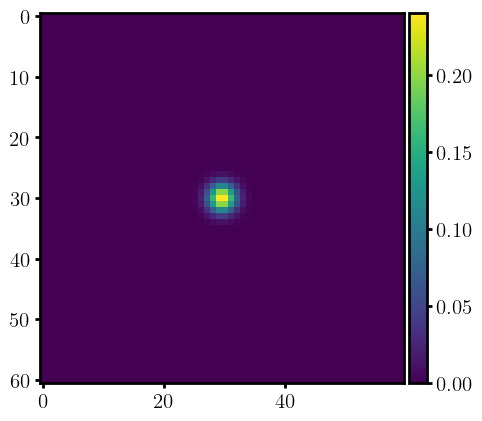

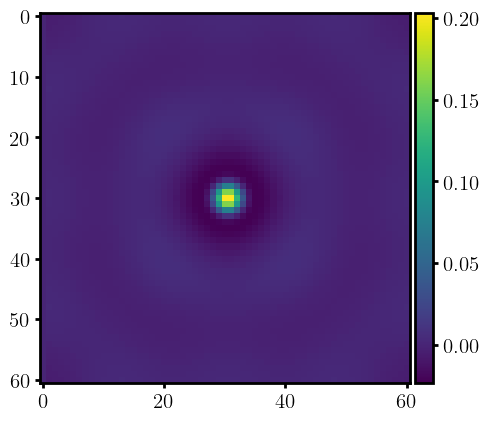

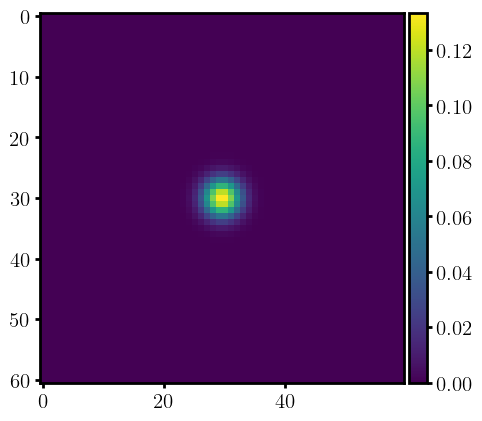

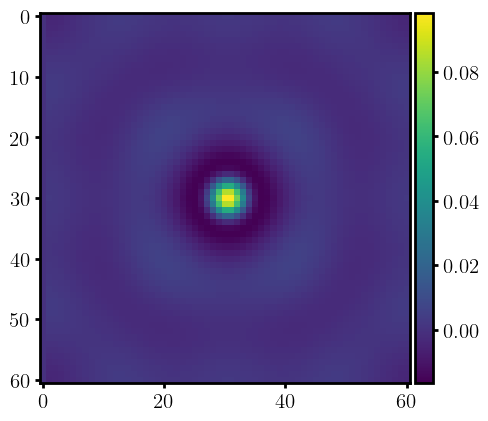

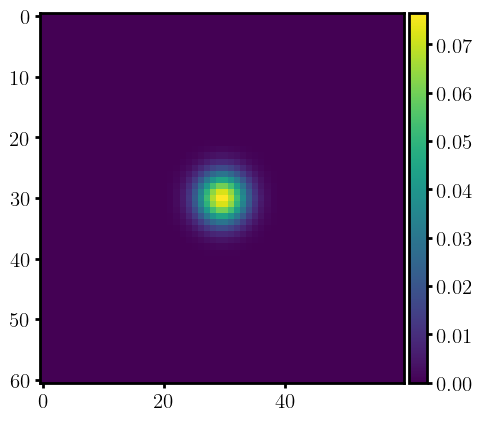

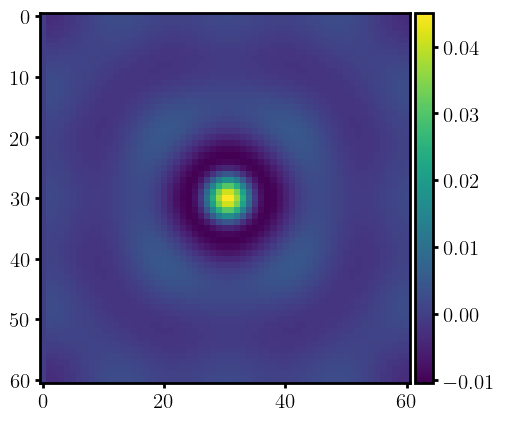

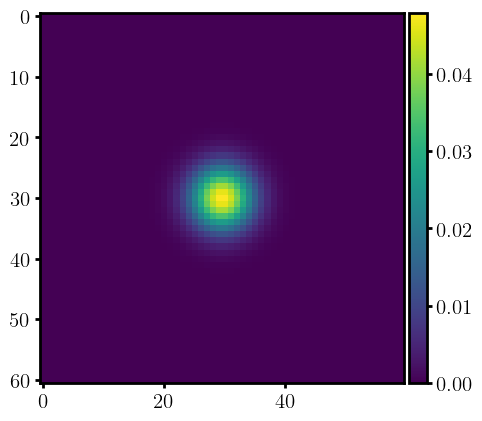

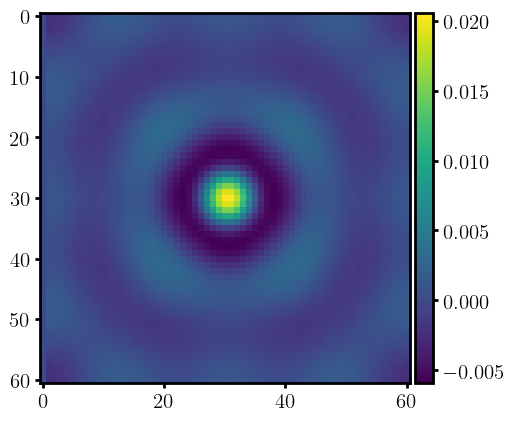

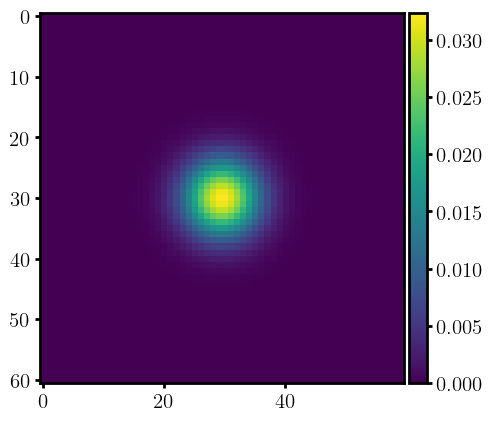

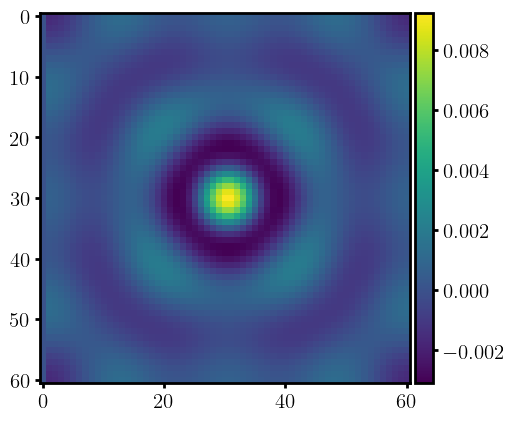

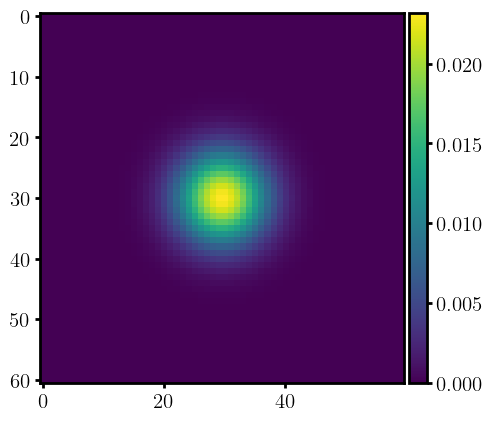

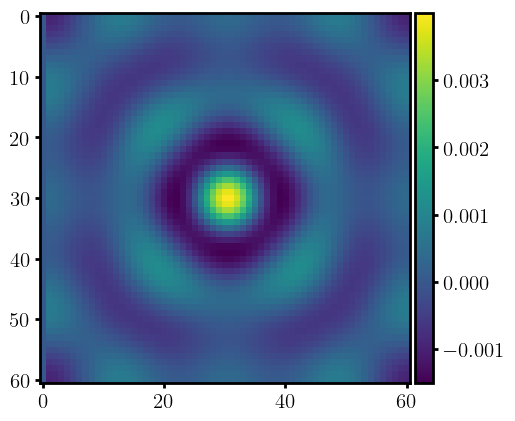

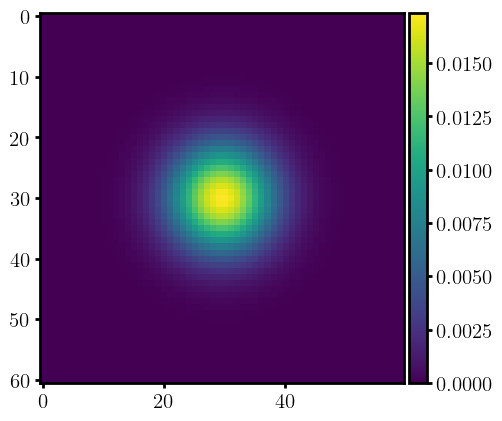

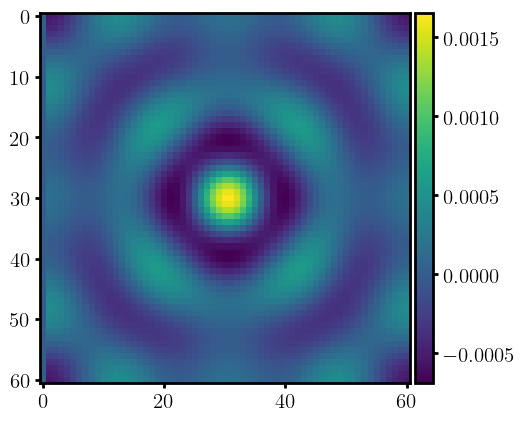

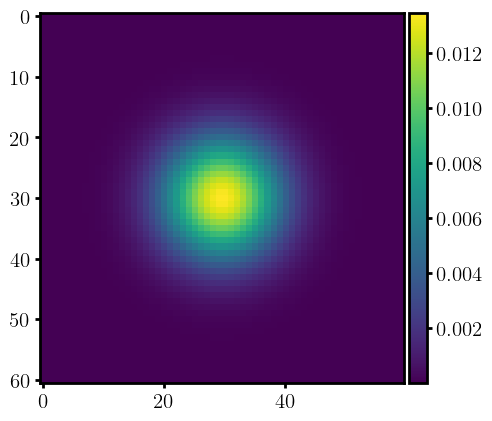

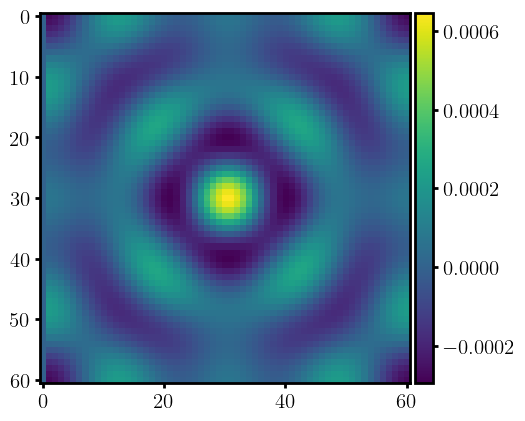

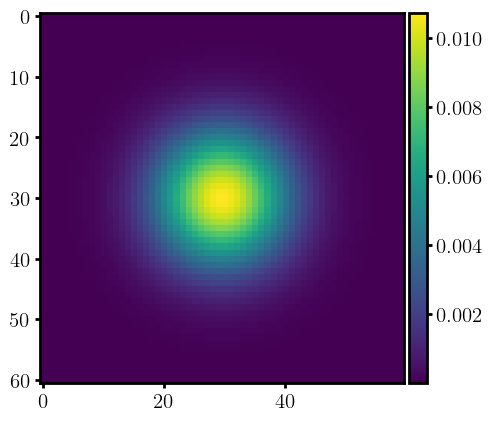

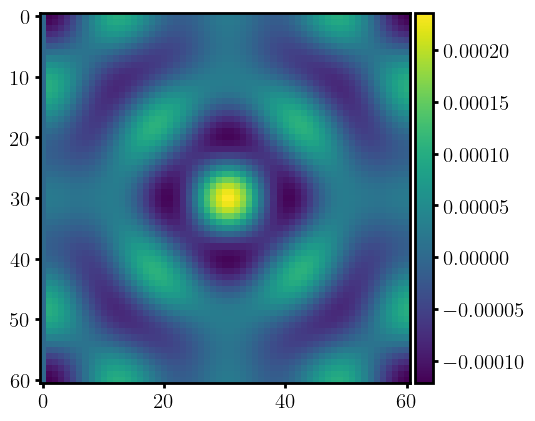

In [199]:
# make single object profile
fwhms = np.linspace(1,9,9)
f, ax = plt.subplots(1,1)
for fwhm in fwhms:
    baseMap, boxMask, wcs = make_stampmap()
    dmap = make_ptsrc_map(baseMap, plot=False)
    gmap = gaussify_map(dmap, fwhm=fwhm, plot=False)
    gmap = beam_map(gmap)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=True)
    RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    plot_mean_tau(RAp, filt_one_profile, ax=ax, c=plt.get_cmap('viridis')(fwhm/len(fwhms)), label=str(fwhm)+'\'')
ax.legend(ncol=2, title=r'$\tau$ FWHM')
ax.set_title(r'Fixed integrated $\tau$ profile=1 arcmin$^2$')
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')

/tmp/ipykernel_177230/2865692060.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure()


Text(0, 0.5, '$\\langle \\tau \\rangle$')

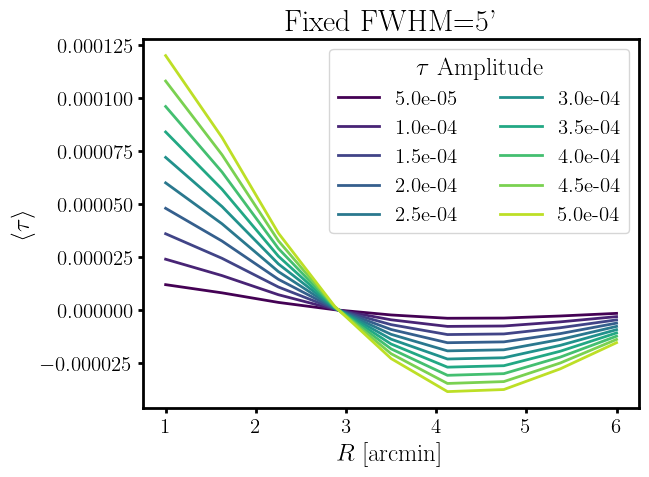

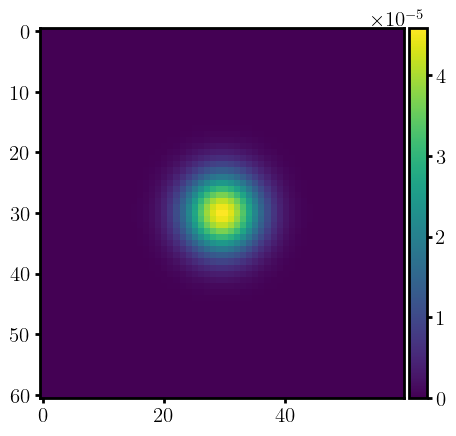

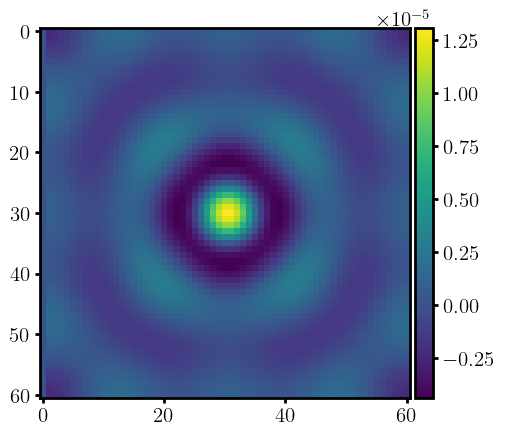

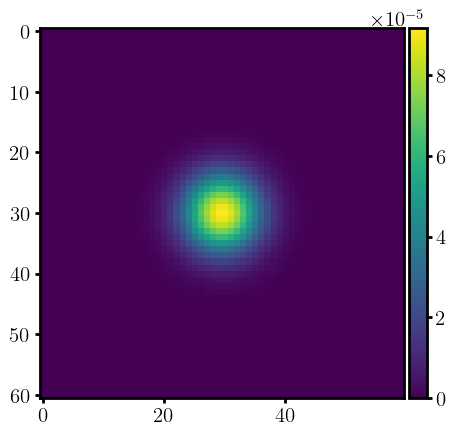

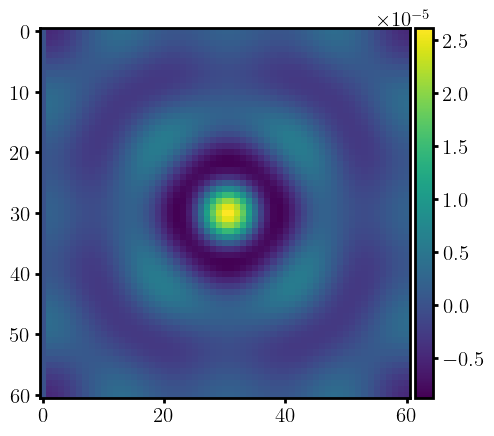

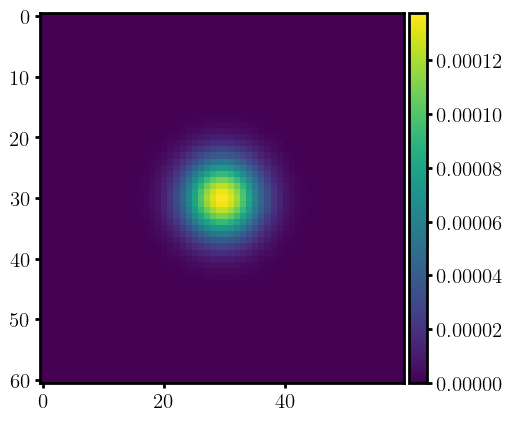

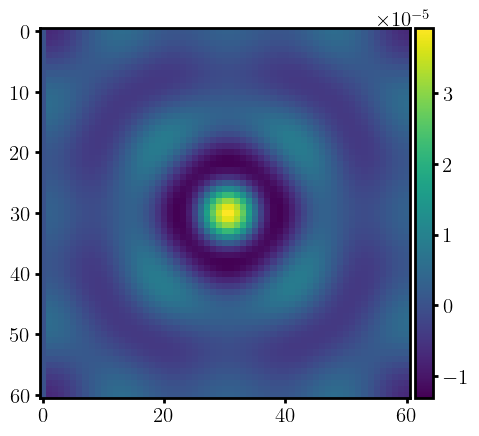

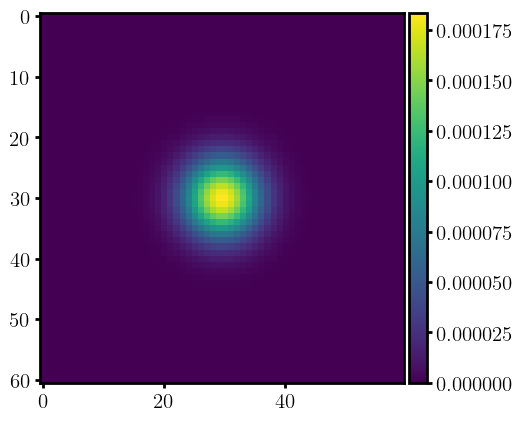

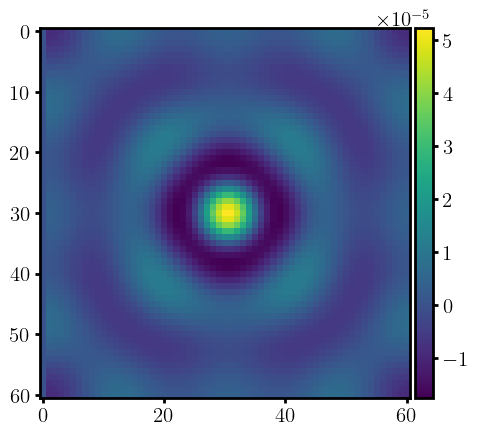

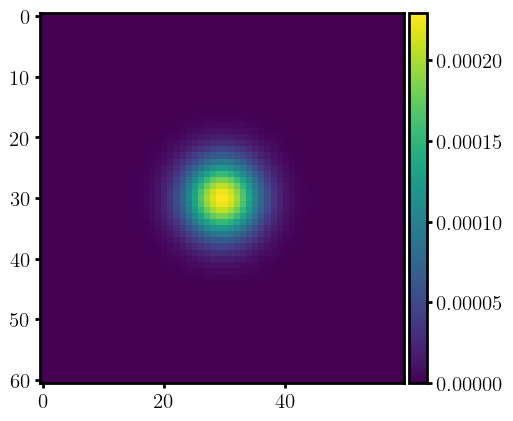

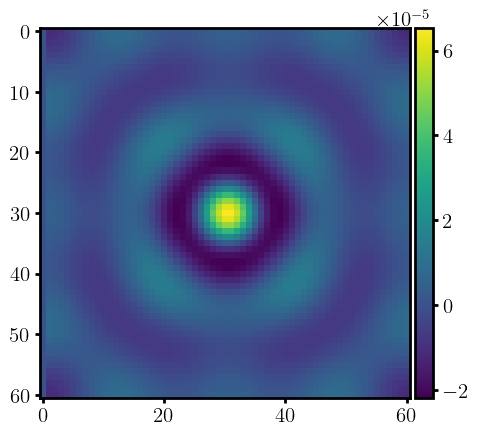

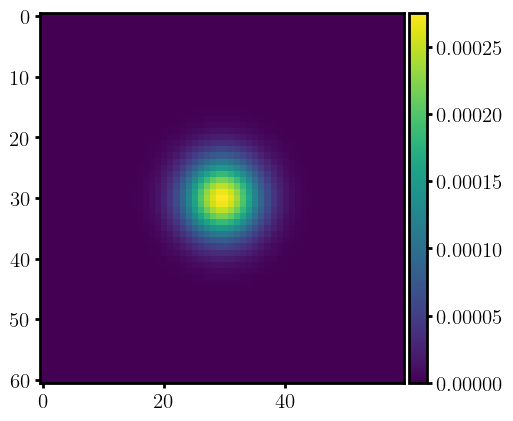

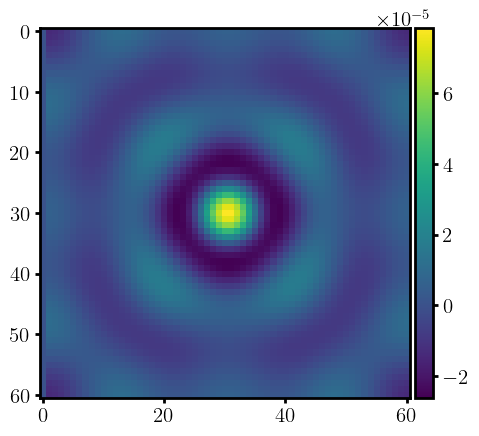

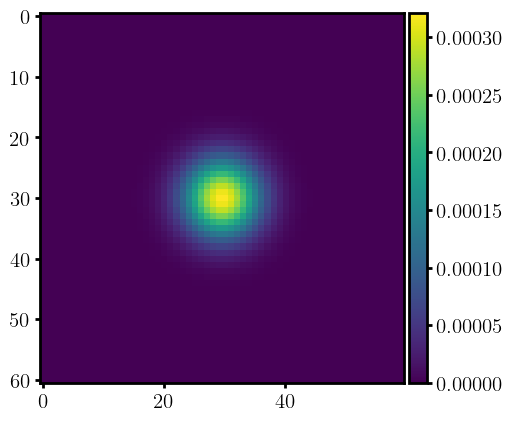

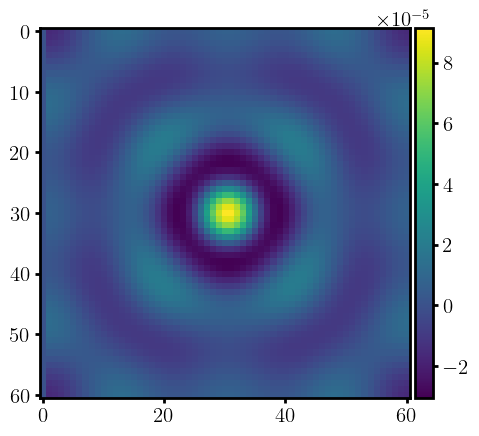

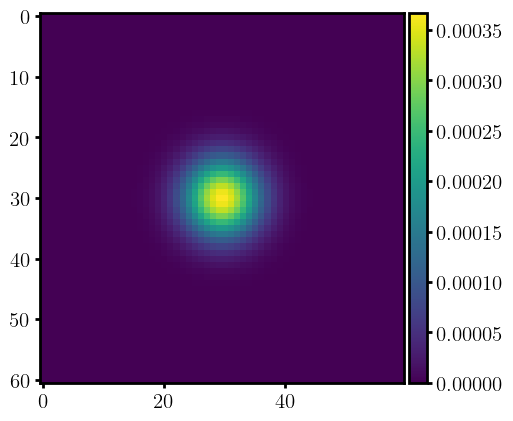

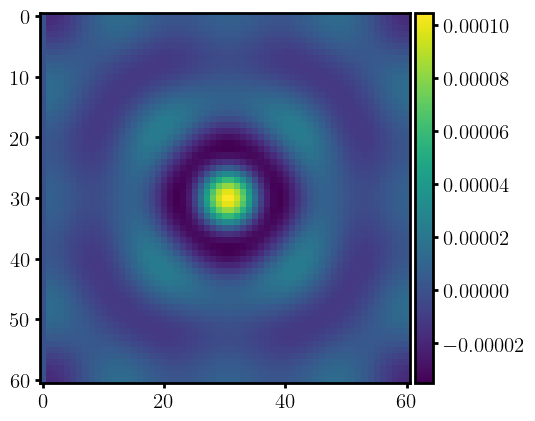

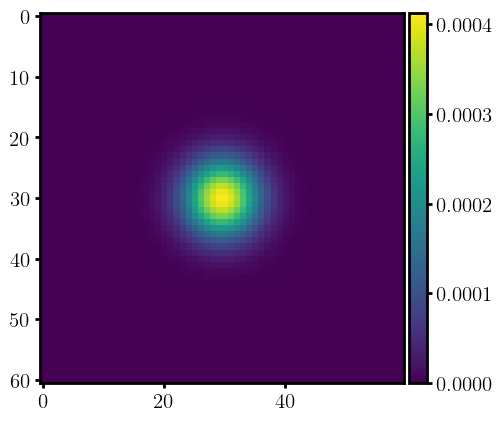

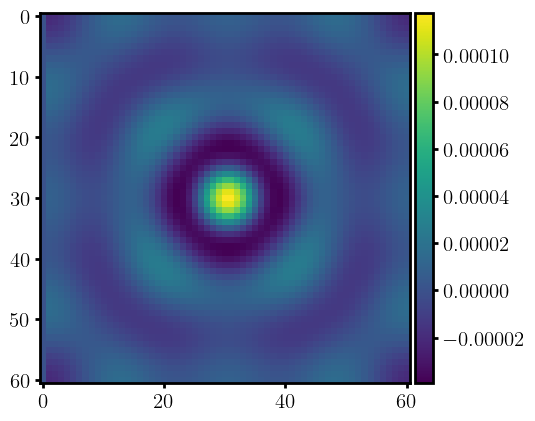

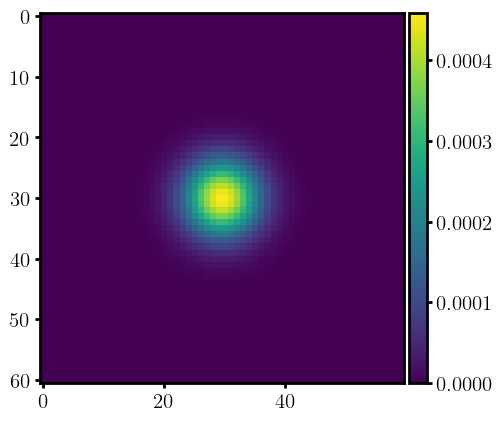

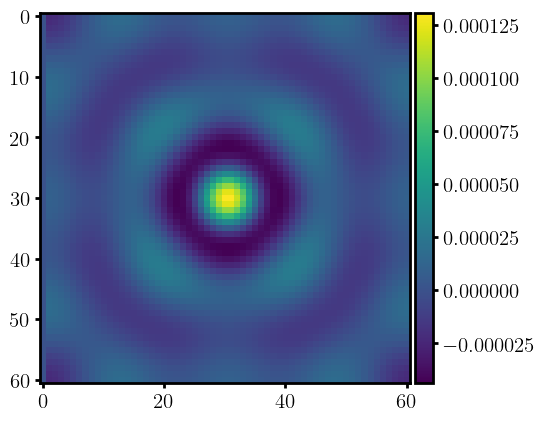

In [196]:
# make single object profile
norms = np.linspace(5e-5, 5e-4, 10)
f, ax = plt.subplots(1,1)
for i, norm in enumerate(norms):
    baseMap, boxMask, wcs = make_stampmap()
    dmap = make_ptsrc_map(baseMap, plot=False)
    gmap = gaussify_map(dmap, fwhm=5., plot=False)
    gmap = renorm_map(gmap, renorm=norm, profile_fwhm=5., plot=False)
    gmap = beam_map(gmap)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=True)
    RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    plot_mean_tau(RAp, filt_one_profile, ax=ax, c=plt.get_cmap('viridis')(i/len(norms)), label='%.1e'%norm)
ax.legend(ncol=2, title=r'$\tau$ Amplitude')
ax.set_title('Fixed FWHM=5\'')
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')

## Check norm for map sent to Abhi...

415.26791240098106
103.81697810024527
212.75776221534528
53.18944055383632


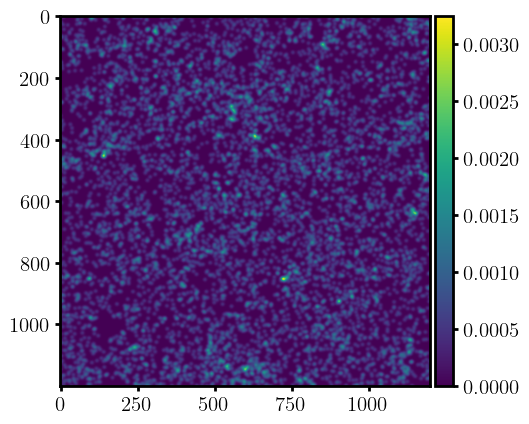

In [20]:
cmass_sent = fitsio.read('/home/theo/Downloads/cmass_m_10x10_tau-fwhm5_renorm2.45e-4_beam1.6_v2_image.fits')
print(np.sum(cmass_sent))
print(np.sum(cmass_sent) * pixarea) #approximate pixel area in arcmin^2
print(np.sum(gmap.data) * 7666)
print(np.sum(gmap.data) * 7666 * 0.25)
f = plt.figure()
im = plt.imshow(cmass_sent)
colorbar(im)

## map sent to Abhi had the factor of 2... T-T